# Plot Venn Diagrams between 2 experiments

Experiments
* Handpicked 37 jets (Guo et al. 2022)
* Fontanka (Galitsyna et al., 2023) 
* Fun (Liu et al., 2024) 
* MIA-Jet 

In [1]:
import sys
sys.path.append('..')
from utils.plotting import plot_hic, plot_n_hic, genomic_labels
from utils.processing import read_hic_file

In [2]:
import pandas as pd
import itertools
import pybedtools
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import bioframe as bf
import numpy as np
import re
from shapely.geometry import LineString, Point
from collections import defaultdict
from shapely.geometry import MultiPoint
from tqdm import tqdm

import networkx as nx      

In [3]:
def generate_positions(df, resolution):
    """
    For each row in df:
      1. Build p1=(extrusion_x, extrusion_y) and p2=(root, root)
      2. Compute the convex hull (a LineString) between p1 and p2
      3. Measure its length, decide how many points to sample (at least 2)
      4. Interpolate that many evenly spaced points along the hull
      5. Emit one row per interpolated point with columns: unique_id, x (bp), y (bp)
    """
    rows = []

    for _, row in df.iterrows():
        # define extrusion point of jet
        p1 = (row["extrusion_x"], row["extrusion_y"]) 
        # define root point of jet (on main diagonal)
        p2 = (row["root"], row["root"])

        # construct convex hull between poitns
        hull = MultiPoint([p1, p2]).convex_hull  
        
        # compute the number of points to sample along the hull
        # this is dependent on the resolution
        distance = hull.length        
        num_points = np.ceil(distance / resolution).astype(int)
        num_points = max(num_points, 2)  # Ensure at least two points
        
        # extract coordinates
        alpha = np.linspace(0, 1, num_points)
        coords = [hull.interpolate(a, normalized=True).coords[0] for a in alpha]
        
        for x_bp, y_bp in coords:
            rows.append({
                "unique_id": row["unique_id"],
                "chrom": row["chrom"],
                "x (bp)":    x_bp,
                "y (bp)":    y_bp
            })

    return pd.DataFrame.from_records(rows)



def plot_overlap_diagnostic(hic_file, plot_chrom, resolution, data_type, normalization,
                            A_name, B_name, 
                            df_pos_A, df_pos_B,
                            df_pos_intersection, 
                            df_pos_diff_A, df_pos_diff_B, 
                            save_path, data_name):
    """
    Plot the diagnostic Hi-C plots for the overlap of jets
    """
    H = read_hic_file(hic_file, chrom=plot_chrom, resolution=resolution, positions="all", 
                      data_type=data_type, normalization=normalization, verbose=False)

    if data_type == "observed":
        H = np.log10(H + 1)  # log transform for better visualization

    # Select the postiions for the chromosomes
    df_pos_A_chrom = df_pos_A[df_pos_A["chrom"] == plot_chrom].copy()
    # Bin
    df_pos_A_chrom["x_bin"] = np.ceil(df_pos_A_chrom["x (bp)"] / resolution).astype(int)
    df_pos_A_chrom["y_bin"] = np.ceil(df_pos_A_chrom["y (bp)"] / resolution).astype(int)

    # Repeat for each dataframe (A, B, A - intersection, B - intersection, intersection)
    df_pos_B_chrom = df_pos_B[df_pos_B["chrom"] == plot_chrom].copy()
    df_pos_B_chrom["x_bin"] = np.ceil(df_pos_B_chrom["x (bp)"] / resolution).astype(int)
    df_pos_B_chrom["y_bin"] = np.ceil(df_pos_B_chrom["y (bp)"] / resolution).astype(int)

    df_pos_diff_A_chrom = df_pos_diff_A[df_pos_diff_A["chrom"] == plot_chrom].copy()
    df_pos_diff_A_chrom["x_bin"] = np.ceil(df_pos_diff_A_chrom["x (bp)"] / resolution).astype(int)
    df_pos_diff_A_chrom["y_bin"] = np.ceil(df_pos_diff_A_chrom["y (bp)"] / resolution).astype(int)
    df_pos_diff_B_chrom = df_pos_diff_B[df_pos_diff_B["chrom"] == plot_chrom].copy()
    df_pos_diff_B_chrom["x_bin"] = np.ceil(df_pos_diff_B_chrom["x (bp)"] / resolution).astype(int)
    df_pos_diff_B_chrom["y_bin"] = np.ceil(df_pos_diff_B_chrom["y (bp)"] / resolution).astype(int)

    df_pos_intersection_chrom = df_pos_intersection[df_pos_intersection["chrom"] == plot_chrom].copy()
    df_pos_intersection_chrom["x_bin"] = np.ceil(df_pos_intersection_chrom["x (bp)"] / resolution).astype(int)
    df_pos_intersection_chrom["y_bin"] = np.ceil(df_pos_intersection_chrom["y (bp)"] / resolution).astype(int)

    fig, ax = plt.subplots(figsize=(20, 20), layout="constrained", dpi=400)

    im = ax.imshow(H, cmap="Reds", interpolation="none", vmax=np.percentile(H, 98))
    ax.scatter(df_pos_A_chrom["x_bin"], df_pos_A_chrom["y_bin"], s=0.3, c="blue", label=A_name)
    ax.scatter(df_pos_B_chrom["x_bin"], df_pos_B_chrom["y_bin"], s=0.3, c="green", label=B_name)
    ax.scatter(df_pos_intersection_chrom["y_bin"], df_pos_intersection_chrom["x_bin"], s=0.3, c="cyan", marker="o", label=f"{A_name} AND {B_name}")
    # ax.scatter(df_pos_diff_A_chrom["x_bin"], df_pos_diff_A_chrom["y_bin"], s=3, c="blue", marker="x", label=f"{A_name} - {B_name}", alpha=0.5)
    # ax.scatter(df_pos_diff_B_chrom["x_bin"], df_pos_diff_B_chrom["y_bin"], s=3, c="green", marker="x", label=f"{B_name} - {A_name}", alpha=0.5)

    ax.set_title(f"{data_name} {plot_chrom} Comparison of Jet Called", fontsize=16)

    ax.legend(loc="upper right", fontsize=12)

    plt.savefig(f"{save_path}/{data_name}_diagnostic_{plot_chrom}_{n1}_{n2}_jet_comparison.png", dpi=400)

    plt.close()




def match_by_iou(dfA: pd.DataFrame, dfB: pd.DataFrame, buffer_radius=1.0, iou_threshold=0.0, verbose=False):
    """
    For each unique_id in dfA, build a buffered geometry from its (x (bp), y (bp)) coords,
    then compare to every unique_id in dfB (also buffered), computing intersection-over-union.
    Record the dfB unique_id with the highest IoU > iou_threshold (and non-empty intersection).

    Parameters
    ----------
    dfA, dfB : pd.DataFrame
        Must have columns ["unique_id", "x (bp)", "y (bp)"].
    buffer_radius : float
        How much to buffer each LineString/Point before computing areas.
    iou_threshold : float
        Only record matches whose IoU exceeds this (default 0.0, i.e. any non-empty overlap).

    Returns
    -------
    List of (unique_id_A, unique_id_B) pairs.
    """
    # Precompute buffered geometries for dfB
    geomsB = dict()
    for uid_b, grp_b in dfB.groupby("unique_id"):
        coords_b = list(zip(grp_b["x (bp)"], grp_b["y (bp)"]))
        if len(coords_b) < 2:
            geom_b = Point(coords_b[0]).buffer(buffer_radius)
        else:
            geom_b = LineString(coords_b).buffer(buffer_radius)
        geomsB[uid_b] = geom_b

    matches = []

    # Now for each unique_id in dfA, find best‐matching unique_id in dfB
    gb = dfA.groupby("unique_id")
    for uid_a, grp_a in tqdm(gb, total=len(gb), disable=not verbose):
        coords_a = list(zip(grp_a["x (bp)"], grp_a["y (bp)"]))
        if len(coords_a) < 2:
            geom_a = Point(coords_a[0]).buffer(buffer_radius)
        else:
            geom_a = LineString(coords_a).buffer(buffer_radius)

        best_iou = 0.0
        best_uid_b = None

        for uid_b, geom_b in geomsB.items():
            inter = geom_a.intersection(geom_b).area
            if inter == 0:
                continue
            union = geom_a.union(geom_b).area
            iou = inter / union if union > 0 else 0.0

            if iou > best_iou:
                best_iou = iou
                best_uid_b = uid_b

        if best_uid_b is not None and best_iou > iou_threshold:
            matches.append((uid_a, best_uid_b, best_iou))

    return matches



from typing import List, Tuple, Hashable
PairT = Tuple[Hashable, Hashable, float]

def unique_pairs(pairs_a2b: List[PairT], pairs_b2a: List[PairT], method="optimal") -> List[Tuple[Hashable, Hashable]]:
    """
    Combine two directed match lists and return a list of (A_ID, B_ID)
    such that no ID appears more than once.  If *use_optimal* is True,
    solve the maximum-weight matching; otherwise use a greedy heuristic
    """

    # put every edge in the same orientation
    edges: List[PairT] = []
    for a, b, w in pairs_a2b:
        edges.append((a, b, w))          
    for b, a, w in pairs_b2a:
        edges.append((a, b, w))          # flip 

    if method == "optimal":
        # max_weight_matching method
        G = nx.Graph()
        for a, b, w in edges:
            G.add_edge(f"a.{a}", f"b.{b}", weight=w)  # add tags "a." and "b." to avoid uid collisions
        matching = nx.algorithms.matching.max_weight_matching(G, maxcardinality=False, weight="weight")
        # nx returns unordered 2-tuples; recover original IDs and orientation
        result = []
        for u, v in matching:
            if u.startswith("a."):      # u is left side
                a_id = u[2:]            # strip "a."
                b_id = v[2:]            # strip "b."
            else:
                a_id = v[2:]
                b_id = u[2:]
            result.append((a_id, b_id))
        return result

    else:
        # Greedy method
        # highest IOU first
        edges.sort(key=lambda t: t[2], # sort by weight i.e. IOU
                   reverse=True)   
        used_a = set()
        used_b = set()
        result = []

        for a, b, w in edges:
            if a not in used_a and b not in used_b:
                result.append((a, b))
                used_a.add(a)
                used_b.add(b)
        return result


import hicstraw
import cv2 as cv

def get_pileups_dynamic_resolution(
    hic_file,
    bed_df_in,
    expected_stack_size,
    chrom_sizes,
    chromosomes='all',
    window_range=(None, None),
    data_type="observed",
    normalization="KR",
    sort=False,
    verbose=False
):
    """
    Generates Hi-C pileups for each region in bed_df_in, choosing for each
    region the resolution (from hic.getResolutions()) that makes
    (region_length / resolution) as close as possible to expected_stack_size.

    Parameters
    ----------
    hic_file : str
        Path to your Hi-C .hic file.
    bed_df_in : pandas.DataFrame
        Must contain columns ['chrom', 'start', 'end'].
    expected_stack_size : int
        Desired number of bins per side of your square pileup.
    chrom_sizes : pandas.DataFrame
        Columns ['chrom', 'length'] (or 'name','length' after trimming).
    chromosomes : 'all' | list of str | str
        Which chroms to include.
    window_range : tuple(int|None, int|None)
        (upstream, downstream) around the midpoint to override bed_df_in.
    data_type : str
        e.g. "observed", "oe", etc.
    normalization : str
        e.g. "KR", "VC", ...
    sort : bool
        If True, sorts bed_df naturally by chrom, start, end.

    Returns
    -------
    pileups : list of 2D np.ndarray
        Each is a square matrix of Hi-C contacts at the chosen resolution.
    bed_df_out : pandas.DataFrame
        The (possibly trimmed, sorted) DataFrame actually used.
    """

    if bed_df_in.empty:
        print("Warning: Empty bed_df_in provided. Returning empty results.")
        return [np.zeros((expected_stack_size, expected_stack_size))], pd.DataFrame(), []

    # 1) Copy & optional sort
    bed_df = bed_df_in.copy()
    if sort:
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            return {'x':23,'y':24,'m':25,'mt':25}.get(cl[-2:] if len(cl)>1 else cl[-1],100)
        bed_df['_ck'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['_ck','start','end']).drop(columns=['_ck']).reset_index(drop=True)

    # 2) apply window_range if given
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['mid'] = ((bed_df['start'] + bed_df['end'])//2)
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['mid'] - win_up
        bed_df['end']   = bed_df['mid'] + win_down
        bed_df = bed_df.drop(columns=['mid'])
        # bioframe.trim wants a 'name' column on chrom_sizes
        chrom_sizes = chrom_sizes.copy()
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes).dropna().reset_index(drop=True)
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)

    # 3) restrict to desired chromosomes
    if chromosomes == 'all':
        chrom_set = bed_df['chrom'].unique().tolist()
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        chrom_set = list(set(bed_df['chrom']).intersection(chromosomes))
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # 4) open hic & fetch available resolutions
    hic = hicstraw.HiCFile(hic_file)
    avail_res = sorted(hic.getResolutions())  # e.g. [500,1000,5000,...]

    # determine whether 'chr' prefix is used in the file
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # 5) build pileups
    pileups = []
    selected_resolutions = []
    for _, row in tqdm(bed_df.iterrows(), total=len(bed_df), desc="Retrieving pileups", disable=not verbose):
        chrom = row['chrom']
        key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom

        # compute jet length
        length = int(row['end']) - int(row['start'])

        # 1) find all resolutions that yield ≥ target bins
        #    i.e. length / r >= target -> r <= length / target
        candidates = [r for r in avail_res if length / r >= expected_stack_size]

        if candidates:
            # select the largest resolution that still gives you enough pixels
            best_res = max(candidates)
        else:
            # if none can give you that many pixels, fall back
            #     to the closest in absolute terms 
            best_res = min(avail_res, key=lambda r: abs((length / r) - expected_stack_size))
            print(f"\tWarning: No resolution that guarantees the matrix size to be {expected_stack_size}")
            print(f"\tThe closest resolution is {best_res} yielding a {int(length / best_res)} size matrix")

        selected_resolutions.append(best_res)

        # fetch matrix zoom data at that resolution
        mzd = hic.getMatrixZoomData(
            key, key,
            data_type, 
            normalization,
            'BP',
            best_res
        )

        # extract the pileup
        mat = mzd.getRecordsAsMatrix(
            int(row['start']), int(row['end']),
            int(row['start']), int(row['end'])
        )
        pileups.append(mat)

    return pileups, bed_df, selected_resolutions



def get_pileups(hic_file, bed_df_in, resolution, chrom_sizes,
                chromosomes='all', window_range=(None, None),
                data_type="observed", normalization="KR", sort=False):
    """
    Processes Hi-C data to generate pileups for genomic regions specified in a BED-format DataFrame

    Returns:
    --------
    pileups : list of numpy arrays
        Each array is a pileup matrix of Hi-C interaction data.
    bed_df  : pandas DataFrame
        Possibly sorted and trimmed bed DataFrame used for pileups.
    """
    bed_df = bed_df_in.copy()

    # Optional sort on natural chromosome order
    if sort:
        # Define a key function for numeric and special chromosomes
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            if cl.endswith('x'):
                return 23
            if cl.endswith('y'):
                return 24
            if cl.endswith(('m', 'mt')):
                return 25
            return 100

        bed_df['sort_key'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['sort_key', 'start', 'end'])
        bed_df = bed_df.drop(columns=['sort_key']).reset_index(drop=True)

    # Handle custom window around midpoints
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['midpoint'] = ((bed_df['start'] + bed_df['end']) // 2)
        # default missing values
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['midpoint'] - win_up
        bed_df['end'] = bed_df['midpoint'] + win_down
        bed_df = bed_df.drop(columns=['midpoint'])
        # Trim out-of-bounds
        # bioframe.trim expects a 'name' column on chrom_sizes
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes)
        bed_df = bed_df.dropna().reset_index(drop=True)
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)

    # Determine which chromosomes to include
    if chromosomes == 'all':
        chrom_set = list(bed_df['chrom'].unique())
    elif isinstance(chromosomes, (list, np.ndarray)):
        chrom_set = list(set(bed_df['chrom'].unique()) & set(chromosomes))
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        print(f"Warning: 'chromosomes' argument improperly formatted: {chromosomes}")
        chrom_set = list(bed_df['chrom'].unique())

    # Filter bed_df by chrom_set in both branches
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # Open Hi-C file and detect prefix usage
    hic = hicstraw.HiCFile(hic_file)
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # Build pileups
    pileups = []
    if sort:
        for chrom in chrom_set:
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            sub = bed_df[bed_df['chrom'] == chrom]
            for _, row in tqdm(sub.iterrows(), total=len(sub)):
                mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                             int(row['start']), int(row['end']))
                pileups.append(mat)
    else:
        for _, row in tqdm(bed_df.iterrows(), total=len(bed_df)):
            chrom = row['chrom']
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                         int(row['start']), int(row['end']))
            pileups.append(mat)

    return pileups, bed_df


def remove_stack_centromeres(stack, stack_positions, expected_stack_size):
    '''
    Essentially removes Hi-C windows in the stack that are not size `expected_stack_size`
    Returns modified stack, stack_positions
    '''
    # process centromeres
    stack_uniform = []
    problem = []
    for i, each in enumerate(stack):
        if each.shape[0] != expected_stack_size:
            problem.append(i)
        else:
            stack_uniform.append(each)

    stack = np.array(stack_uniform)
    stack_positions = stack_positions.drop(problem, axis=0).reset_index(drop=True)
    assert stack.shape[0] == len(stack_positions)
    return stack, stack_positions


def remove_and_resize_square_stacks(stack, stack_positions, expected_stack_size):
    """
    Filters out any arrays in `stack` that aren’t square, then
    resizes the remaining square arrays to (expected_stack_size, expected_stack_size).

    Parameters
    ----------
    stack : Sequence of 2D numpy arrays
        Each array should represent a Hi-C window.
    stack_positions : pandas.DataFrame
        Positions corresponding to each entry in `stack`.
    expected_stack_size : int
        The desired width and height for all retained windows.

    Returns
    -------
    (np.ndarray, pandas.DataFrame)
        - stack_resized: Array of shape (n_retained, expected_stack_size, expected_stack_size)
        - stack_positions_filtered: DataFrame of length n_retained
    """
    if stack_positions.empty:
        return stack, stack_positions

    stack_uniform = []
    bad_indices = []

    for i, arr in enumerate(stack):
        # check it's 2D and square
        if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
            bad_indices.append(i)
            continue

        # resize square array to expected_stack_size × expected_stack_size
        resized = cv.resize(
            arr,
            (expected_stack_size, expected_stack_size),
            interpolation=cv.INTER_AREA
        )
        stack_uniform.append(resized)

    # build numpy array of resized windows
    stack_resized = np.array(stack_uniform)

    # drop bad rows from positions, reset index
    stack_positions_filtered = (
        stack_positions
        .drop(index=bad_indices, errors='ignore')
        .reset_index(drop=True)
    )

    # sanity check
    assert stack_resized.shape[0] == len(stack_positions_filtered), (
        f"Number of retained stacks ({stack_resized.shape[0]}) "
        f"does not match positions ({len(stack_positions_filtered)})"
    )

    return stack_resized, stack_positions_filtered


def assign_start_end(row):
    
    if row["x (bp)"].min() < row["y (bp)"].max():
        start = row["x (bp)"].min()
        end = row["y (bp)"].max()
    else:
        start = row["y (bp)"].min()
        end = row["x (bp)"].max()
    
    return pd.Series({"start": start, "end": end})


def generate_bed_df(df_summary, df_expanded, eps, fraction):
    """
    Generate a summary dataframe (bed file) that contains
    "chrom", "start", "end", in addition to all other columns in df_summary

    The "start" and "end" is computed to be the maximum extrusion point of the jet,
    where "maximum" is defined relative to the main diagonal

    The `eps` and `fraction` parameters controls the additional margin around the maximum extrusion point
    * `eps` is the fixed margin in basepairs
    * `fraction` is the fraction increase of the window size around the maximum extrusion point
    """
    if df_summary.empty or df_expanded.empty:
        return pd.DataFrame()

    # Need to make new columns for the window boundaries of aggregate plotting
    df_plot_summary = df_expanded.groupby('unique_id').apply(assign_start_end, include_groups=False).reset_index()

    assert np.all(df_plot_summary['end'] >= df_plot_summary['start'])

    # Epsilon margin around the maximum extrusion point
    curr_window_size = df_plot_summary['end'] - df_plot_summary['start']
    df_plot_summary['start'] -= curr_window_size * fraction + eps
    df_plot_summary['end'] += curr_window_size * fraction + eps
    
    # just keep the essentials for merging 
    df_plot_summary = df_plot_summary[['unique_id','start','end']]

    df_summary_copy = df_summary.copy()

    # Drop start and end columns of the old summary dataframe (this is generated from the miajet program)
    df_summary_copy = df_summary_copy.drop(columns=['start', 'end'])

    # Join on "unique_id" with df_plot_summary
    df_summary_copy = df_summary_copy.merge(df_plot_summary, on='unique_id', how='inner')

    return df_summary_copy


def safe_int(x):
    try:
        return int(x)
    except ValueError:
        return x





# Across all experiments

In [4]:
experiments = [
    # {   # SUCCESSFULLY GENERATED
    #     "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic",
    #     "data_name": "Repli-HiC_K562_WT_totalS",
    #     "genome": "hg19",
    # },
    {   # SUCCESSFULLY GENERATED
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped.hic",
        "data_name": "DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped",
        "genome": "mm10",
    },
    {   # SUCCESSFULLY GENERATED
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic",
        "data_name": "splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9",
        "genome": "mm9",
    },
]

save_path = "/nfs/turbo/umms-minjilab/sionkim/miajet_analysis"

# standard parameters
miajet_result_type = "saliency-90-p-0.1"  
resolution = 50000  # 50Kb
expected_stack_size = 100
data_type = "oe"
normalization = "KR"
buffer_radius = 3 * resolution  # 3 bins
iou_threshold = 0  # ANY overlap

# fixed method names
names = [f"MIA-Jet {miajet_result_type}", "Fun", "Fontanka"]

for exp in experiments:
    hic_file = exp["hic_file"]
    data_name = exp["data_name"]
    genome = exp["genome"]

    # ----------------------------------------------------------------
    # Paths to each caller’s predictions, built from data_name + genome
    # ----------------------------------------------------------------
    # FUN
    f_pred_fun_bedpe = (
        f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/"
        f"FUN_{data_name}_{genome}/FUN-pred_{resolution}_1.3.bedpe"
    )
    f_pred_fun_tab = (
        f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/"
        f"FUN_{data_name}_{genome}/FUN-pred_{resolution}_1.3.tab"
    )

    # FONTANKA
    f_pred_fontanka = (
        f"/nfs/turbo/umms-minjilab/sionkim/jet_pred/"
        f"FONTANKA_{data_name}.{resolution}.predicted.fountains.thresholded.tsv"
    )

    # MIA-JET
    f_pred_miajet_summary = (
        f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/"
        f"{data_name}_chr_combined_{genomic_labels(resolution)}/"
        f"{data_name}_chr_combined_{miajet_result_type}_{genomic_labels(resolution)}_summary_table.csv"
    )
    f_pred_miajet_expanded = (
        f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/"
        f"{data_name}_chr_combined_{genomic_labels(resolution)}/"
        f"{data_name}_chr_combined_{miajet_result_type}_{genomic_labels(resolution)}_expanded_table.csv"
    )

    # --------------------------------
    # Read in each method’s output
    # --------------------------------
    fun_bedpe = pd.read_csv(f_pred_fun_bedpe, sep="\t")
    fun_table = pd.read_csv(f_pred_fun_tab, sep="\t")

    fontanka_table = pd.read_csv(f_pred_fontanka, sep="\t", index_col=0)
    fontanka_table.dropna(inplace=True, how="any")
    fontanka_table.reset_index(inplace=True, drop=True)

    miajet_positions = pd.read_csv(f_pred_miajet_expanded, comment="#")
    miajet_table     = pd.read_csv(f_pred_miajet_summary, comment="#")

    # ------------------------------------------
    # Restrict to common chromosomes
    # ------------------------------------------
    common_chroms = (
        set(fun_table["chrom"].unique())
        & set(fontanka_table["chrom"].unique())
        & set(miajet_table["chrom"].unique())
    )
    common_chroms = list(common_chroms)

    for df in (fun_table, fontanka_table, miajet_table):
        df.dropna(subset=["chrom"], inplace=True)
    fun_table     = fun_table    [fun_table["chrom"].isin(common_chroms)]
    fontanka_table = fontanka_table[fontanka_table["chrom"].isin(common_chroms)]
    miajet_table  = miajet_table [miajet_table["chrom"].isin(common_chroms)]

    print(f"[{data_name}] Common chromosomes: {common_chroms}")

    # ------------------------------------------
    # Build minimal “positions” tables for each
    # ------------------------------------------
    # FUN
    fun_bedpe["extrusion_x"] = (fun_bedpe["y1"] + fun_bedpe["y2"]) / 2
    fun_bedpe["extrusion_y"] = (fun_bedpe["x1"] + fun_bedpe["x2"]) / 2
    fun_table["root"]        = (fun_table["start"] + fun_table["end"]) / 2
    fun_table["unique_id"]   = fun_table.index
    fun_minimal = fun_bedpe.copy()
    fun_minimal["root"]      = fun_table["root"]
    fun_minimal["unique_id"] = fun_minimal.index
    fun_minimal["chrom"]     = fun_table["chrom"]
    fun_minimal = fun_minimal[["unique_id","chrom","root","extrusion_x","extrusion_y"]]
    fun_positions = generate_positions(fun_minimal, resolution)
    fun_positions["unique_id"] = fun_positions["unique_id"].astype(int)

    # FONTANKA
    fontanka_table["root"]      = (fontanka_table["end"] + fontanka_table["start"]) / 2
    fontanka_table["unique_id"] = fontanka_table.index
    fontanka_table["extrusion_x"] = fontanka_table["window_end"]
    fontanka_table["extrusion_y"] = fontanka_table["window_start"]
    fontanka_minimal = fontanka_table[["unique_id","chrom","root","extrusion_x","extrusion_y"]].copy()
    fontanka_positions = generate_positions(fontanka_minimal, resolution)
    fontanka_positions["unique_id"] = fontanka_positions["unique_id"].astype(int)

    # MIA-JET
    # (already loaded as `miajet_positions`)

    # ------------------------------------------
    # Prepare for pairwise overlaps
    # ------------------------------------------
    positions = [miajet_positions, fun_positions, fontanka_positions]
    tables    = [miajet_table,     fun_table,     fontanka_table]

    position_dict = dict(zip(names, positions))
    table_dict    = dict(zip(names, tables))

    # initialize results matrix
    results = pd.DataFrame(index=names, columns=names, dtype=int).fillna(0)
    for n in names:
        results.loc[n,n] = len(table_dict[n])

    unique_identifiers = []
    name_pairs = []
    for n1,n2 in itertools.combinations(names,2):
        genome_wide_overlap = 0
        identifiers = []
        for chrom in common_chroms:
            t1 = position_dict[n1].loc[position_dict[n1]["chrom"] == chrom]
            t2 = position_dict[n2].loc[position_dict[n2]["chrom"] == chrom]
            pairs12 = match_by_iou(t1, t2, buffer_radius, iou_threshold)
            pairs21 = match_by_iou(t2, t1, buffer_radius, iou_threshold)
            pairs   = unique_pairs(pairs12, pairs21, method="optimal")
            genome_wide_overlap += len(pairs)
            identifiers += pairs
        results.loc[n1,n2] = genome_wide_overlap
        results.loc[n2,n1] = genome_wide_overlap
        unique_identifiers.append(identifiers)
        name_pairs.append((n1,n2))

    print(f"[{data_name}] Genome-wide overlaps:\n", results)

    # ------------------------------------------
    # Make the Venn + mean-contact plots
    # ------------------------------------------
    # Plot in a loop, including the diagnostic plot call
    agg_map_pairs = []
    for (n1, n2), pairs in zip(name_pairs, unique_identifiers):
        # keep the original variable names
        A_name, B_name = n1, n2

        # vectorize safe_int
        safe_convert = np.vectorize(safe_int)
        u = np.array(pairs)
        uid1 = safe_convert(u[:, 0])
        uid2 = safe_convert(u[:, 1])

        df1 = pd.DataFrame({"unique_id": uid1})
        df2 = pd.DataFrame({"unique_id": uid2})

        df_A = table_dict[A_name]
        df_B = table_dict[B_name]

        df_intersection = df_A[df_A["unique_id"].isin(df1["unique_id"])].reset_index(drop=True)
        df_diff_A      = df_A[~df_A["unique_id"].isin(df1["unique_id"])].reset_index(drop=True)
        df_diff_B      = df_B[~df_B["unique_id"].isin(df2["unique_id"])].reset_index(drop=True)

        df_pos_A            = position_dict[A_name]
        df_pos_B            = position_dict[B_name]
        df_pos_intersection = df_pos_A[df_pos_A["unique_id"].isin(df1["unique_id"])].reset_index(drop=True)
        df_pos_diff_A       = df_pos_A[~df_pos_A["unique_id"].isin(df1["unique_id"])].reset_index(drop=True)
        df_pos_diff_B       = df_pos_B[~df_pos_B["unique_id"].isin(df2["unique_id"])].reset_index(drop=True)

        # diagnostic plot for this pair
        plot_overlap_diagnostic(
            hic_file=hic_file,
            plot_chrom=common_chroms[0],
            resolution=resolution,
            data_type="observed",
            normalization="VC_SQRT",
            A_name=A_name,
            B_name=B_name,
            df_pos_A=df_pos_A,
            df_pos_B=df_pos_B,
            df_pos_intersection=df_pos_intersection,
            df_pos_diff_A=df_pos_diff_A,
            df_pos_diff_B=df_pos_diff_B,
            save_path=save_path,
            data_name=data_name
        )

        # now generate the BEDs and mean-contact maps as before
        bed_intersection = generate_bed_df(df_intersection, df_pos_intersection, eps=500e3, fraction=0.5)
        bed_diff_A      = generate_bed_df(df_diff_A,       df_pos_diff_A,       eps=500e3, fraction=0.5)
        bed_diff_B      = generate_bed_df(df_diff_B,       df_pos_diff_B,       eps=500e3, fraction=0.5)

        chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)
        bed_frames   = [bed_diff_A, bed_intersection, bed_diff_B]

        agg_map = []
        for bed_df in bed_frames:
            s, d, r = get_pileups_dynamic_resolution(
                hic_file=hic_file,
                bed_df_in=bed_df,
                expected_stack_size=expected_stack_size,
                chrom_sizes=chrom_sizes,
                chromosomes='all',
                window_range=(None, None),
                data_type=data_type,
                normalization=normalization,
                sort=True,
                verbose=True
            )
            s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)
            if data_type == "observed":
                s = np.log10(s + 1)
            agg_map.append(np.mean(s, axis=0))

        agg_map_pairs.append(agg_map)


    # plotting grid
    pairs = list(itertools.combinations(names,2))
    num_pairs = len(pairs)
    fig, axes = plt.subplots(num_pairs, 4,
                             figsize=(5*4,5*num_pairs),
                             layout='constrained',
                             width_ratios=[2,1,1,1])

    for row,(A,B) in enumerate(pairs):
        total_A = results.loc[A,A]
        total_B = results.loc[B,B]
        inter   = results.loc[A,B]
        only_A  = total_A - inter
        only_B  = total_B - inter

        ax = axes[row,0]
        venn2((int(only_A), int(only_B), int(inter)),
              set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
              ax=ax)
        ax.set_title(f"{A} vs {B}")

        row_imgs = agg_map_pairs[row]
        for col in range(3):
            ax = axes[row,col+1]
            im = ax.imshow(
                row_imgs[col],
                cmap="Reds",
                interpolation="none",
                vmax=np.percentile(row_imgs[col],99)
            )
            title = [f"{A} only", f"{A} & {B}", f"{B} only"][col]
            count = [only_A, inter, only_B][col]
            ax.set_title(f"{title} (N={int(count)})")
            ax.axis('off')

        fig.colorbar(im, ax=axes[row,1:], fraction=0.02, pad=0.04,
                     label=f"Mean of '{data_type}'")

    fig.suptitle(
        f"Jet Caller Comparison for {data_name}\n"
        f"Overlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution} bp",
        fontsize=16
    )

    plt.savefig(f"{save_path}/{data_name}_venn_diagram.png", dpi=300)
    plt.close()

[DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped] Common chromosomes: ['chr4', 'chr5', 'chr19', 'chr3', 'chr2', 'chr1', 'chrX', 'chr6', 'chr8', 'chr14', 'chr7', 'chr9', 'chr12', 'chr10', 'chr16', 'chr13', 'chr15', 'chr11', 'chr17', 'chr18']
[DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped] Genome-wide overlaps:
                            MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      136.0   110.0      23.0
Fun                                            110.0  1069.0     104.0
Fontanka                                        23.0   104.0     334.0


Retrieving pileups: 100%|██████████| 230/230 [00:03<00:00, 60.96it/s]


[splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9] Common chromosomes: ['chr4', 'chr5', 'chr19', 'chr3', 'chr2', 'chr1', 'chrX', 'chr6', 'chr8', 'chr14', 'chr7', 'chr9', 'chr12', 'chr10', 'chr16', 'chr13', 'chr15', 'chr11', 'chr17', 'chr18']
[splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9] Genome-wide overlaps:
                            MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      154.0   121.0      25.0
Fun                                            121.0  1145.0     101.0
Fontanka                                        25.0   101.0     311.0


Retrieving pileups: 100%|██████████| 210/210 [00:03<00:00, 61.18it/s]


[GSE199059_CD69negDPWTR1R2R3R4_merged] Common chromosomes: ['chr4', 'chr5', 'chr19', 'chr3', 'chr2', 'chr1', 'chrX', 'chr6', 'chr8', 'chr14', 'chr7', 'chr9', 'chr12', 'chr10', 'chr16', 'chr13', 'chr15', 'chr11', 'chr17', 'chr18']
[GSE199059_CD69negDPWTR1R2R3R4_merged] Genome-wide overlaps:
                            MIA-Jet saliency-90-p-0.1     Fun  Fontanka
MIA-Jet saliency-90-p-0.1                      160.0   125.0      27.0
Fun                                            125.0  1095.0     103.0
Fontanka                                        27.0   103.0     320.0


Retrieving pileups:  91%|█████████ | 121/133 [00:04<00:00, 25.96it/s]


KeyboardInterrupt: 

# DP thymocytes (Guo et al. 2022)

The reason why we separate DP thymocyte and other cell lines is because Guo et al. has manual annotations which we consider as another "jet caller" 

In [4]:
hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/GSE199059_CD69negDPWTR1R2R3R4_merged.hic"
data_name = "GSE199059_CD69negDPWTR1R2R3R4_merged"

# FUN
f_pred_fun_bedpe = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_GSE199059_CD69negDPWTR1R2R3R4_merged_mm9/FUN-pred_50000_1.3.bedpe"
f_pred_fun_tab = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_GSE199059_CD69negDPWTR1R2R3R4_merged_mm9/FUN-pred_50000_1.3.tab"

# FONTANKA
f_pred_fontanka = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_GSE199059_CD69negDPWTR1R2R3R4_merged.50000.predicted.fountains.thresholded.tsv"

# MIA-JET
result_type = "saliency-90-p-0.1"
f_pred_miajet_summary = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined_50Kb/GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined_{result_type}_50Kb_summary_table.csv"
f_pred_miajet_expanded = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined_50Kb/GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined_{result_type}_50Kb_expanded_table.csv"

# HAND-PICKED (Guo et al. 2022 DP thymocytes ONLY)
f_guo37 = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/GUO-37_mm9.tsv"

genome = "mm9"



# Common parameters
save_path = "/nfs/turbo/umms-minjilab/sionkim/miajet_analysis"

# Should be the resolution of the miajet program
# This should be standardized across all methods
# This parameter is used to define the sampling frequency of the jet lines 
resolution = 50000 # 50Kb resolution

# Pileup parameters
expected_stack_size = 100
data_type = "oe"
normalization = "KR"

In [5]:
guo37_table = pd.read_csv(f_guo37, sep="\t")

In [6]:
# For the other jet callers, we just copy the code from ##Other cell lines

# Load it in
fun_bedpe = pd.read_csv(f_pred_fun_bedpe, sep="\t")
fun_table = pd.read_csv(f_pred_fun_tab, sep="\t")

fontanka_table = pd.read_csv(f_pred_fontanka, sep="\t", index_col=0)
fontanka_table.dropna(inplace=True, how="any")
fontanka_table.reset_index(inplace=True, drop=True)

miajet_positions = pd.read_csv(f_pred_miajet_expanded, comment="#")
miajet_table = pd.read_csv(f_pred_miajet_summary, comment="#")

# Common chromosome determination
# Lets not include Guo et al. because they didn't find any in chrX
# For a fair comparison of overlaps, we will only consider the common chromosomes
common_chroms = set(fun_table["chrom"].unique()) & set(fontanka_table["chrom"].unique()) & set(miajet_table["chrom"].unique()) 
common_chroms = list(common_chroms)

miajet_table = miajet_table[miajet_table["chrom"].isin(common_chroms)]
fun_table = fun_table[fun_table["chrom"].isin(common_chroms)]
fontanka_table = fontanka_table[fontanka_table["chrom"].isin(common_chroms)]

print(f"Common chromosomes: {common_chroms}")

Common chromosomes: ['chr7', 'chr19', 'chr6', 'chr3', 'chrX', 'chr5', 'chr9', 'chr17', 'chr8', 'chr11', 'chr4', 'chr1', 'chr12', 'chr14', 'chr15', 'chr2', 'chr10', 'chr18', 'chr13', 'chr16']


## Preprocessing

In [7]:
# midpoint
fun_bedpe["extrusion_x"] = (fun_bedpe["y1"] + fun_bedpe["y2"]) / 2
fun_bedpe["extrusion_y"] = (fun_bedpe["x1"] + fun_bedpe["x2"]) / 2

# guarantees that the extrusion point is in the upper diagonal
# doesn't matter except for convention but should be standardized for all points
assert np.all(fun_bedpe["extrusion_x"] >= fun_bedpe["extrusion_y"])

# the main table hosts the "start" and "end" positions, which is the main diagonal start and end
# to get a single point for the jet, we can use the midpoint of the start and end positions
fun_table["root"] = (fun_table["start"] + fun_table["end"]) / 2
# Note that "root" position should technically be "root_x" and "root_y" but since 
# this is a point on the main diagonal, they are the same and we can just use one value

# Lets add a unique identifier now
fun_table["unique_id"] = fun_table.index

# Lets combine them
fun_minimal = fun_bedpe.copy()

fun_minimal["root"] = fun_table["root"]

# Lets add a unique identifier now
fun_minimal["unique_id"] = fun_minimal.index
fun_minimal["chrom"] = fun_table["chrom"]

fun_minimal = fun_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

fun_positions = generate_positions(fun_minimal, resolution)
fun_positions["unique_id"] = fun_positions["unique_id"].astype(int)

fun_positions

,unique_id,chrom,x (bp),y (bp)
0,0,chr1,1.423500e+08,1.416500e+08
1,0,chr1,1.423083e+08,1.416861e+08
2,0,chr1,1.422667e+08,1.417222e+08
3,0,chr1,1.422250e+08,1.417583e+08
4,0,chr1,1.421833e+08,1.417944e+08
...,...,...,...,...
23489,1094,chrX,6.892763e+07,6.863289e+07
23490,1094,chrX,6.888947e+07,6.866842e+07
23491,1094,chrX,6.885132e+07,6.870395e+07
23492,1094,chrX,6.881316e+07,6.873947e+07


In [8]:
fontanka_table = fontanka_table.reset_index(drop=True)
fontanka_table["root"] = (fontanka_table["end"] + fontanka_table["start"]) / 2
fontanka_table["unique_id"] = fontanka_table.index
fontanka_table["extrusion_x"] = fontanka_table["window_end"]
fontanka_table["extrusion_y"] = fontanka_table["window_start"]

# guarantees that the extrusion point is in the upper diagonal
# doesn't matter except for convention but should be standardized for all points
assert np.all(fontanka_table["extrusion_x"] >= fontanka_table["extrusion_y"])

fontanka_minimal = fontanka_table.copy()

fontanka_minimal = fontanka_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

fontanka_positions = generate_positions(fontanka_minimal, resolution)
fontanka_positions["unique_id"] = fontanka_positions["unique_id"].astype(int)

fontanka_positions

,unique_id,chrom,x (bp),y (bp)
0,0,chr1,1.365000e+07,1.600000e+06
1,0,chr1,1.361456e+07,1.635441e+06
2,0,chr1,1.357912e+07,1.670882e+06
3,0,chr1,1.354368e+07,1.706324e+06
4,0,chr1,1.350824e+07,1.741765e+06
...,...,...,...,...
54715,319,chrX,1.526168e+08,1.523332e+08
54716,319,chrX,1.525813e+08,1.523687e+08
54717,319,chrX,1.525459e+08,1.524041e+08
54718,319,chrX,1.525104e+08,1.524396e+08


In [9]:
guo37_table = guo37_table.reset_index(drop=True)

guo37_table["extrusion_x"] = (guo37_table["Pos_kb"] + guo37_table["WT_d2_kb"]) * 1000
guo37_table["extrusion_y"] = (guo37_table["Pos_kb"] - guo37_table["WT_d1_kb"]) * 1000

assert np.all(guo37_table["extrusion_x"] >= guo37_table["extrusion_y"])

guo37_table["root"] = guo37_table["Pos_kb"] * 1000

guo37_table["chrom"] = "chr" + guo37_table["Chr"].astype(str)

guo37_table["unique_id"] = guo37_table.index

guo37_table["start"] = (guo37_table["Pos_kb"] - 1) * 1000
guo37_table["end"] = (guo37_table["Pos_kb"] + 1) * 1000

guo37_minimal = guo37_table.copy()
guo37_minimal = guo37_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]
guo37_positions = generate_positions(guo37_minimal, resolution)


guo37_positions

,unique_id,chrom,x (bp),y (bp)
0,0,chr1,1.905910e+08,1.887005e+08
1,0,chr1,1.905422e+08,1.887148e+08
2,0,chr1,1.904935e+08,1.887290e+08
3,0,chr1,1.904447e+08,1.887432e+08
4,0,chr1,1.903959e+08,1.887575e+08
...,...,...,...,...
772,35,chr19,1.469600e+07,1.462191e+07
773,35,chr19,1.466300e+07,1.466300e+07
774,36,chr19,1.882000e+07,1.862000e+07
775,36,chr19,1.877000e+07,1.867000e+07


## Intersection

In [10]:
# Expanded
positions = [
    miajet_positions,
    fun_positions,
    fontanka_positions, 
    guo37_positions
]

# Summary
tables = [
    miajet_table,
    fun_table,
    fontanka_table,
    guo37_table
]

names = [
    "MIA-Jet",
    "Fun",
    "Fontanka",
    "Guo et al. 2022"
]

position_dict = dict(zip(names, positions))
table_dict = dict(zip(names, tables))

In [11]:
buffer_radius = 3 * resolution  # 5 bins
iou_threshold = 0  # ANY overlap

In [12]:
results = pd.DataFrame(index=names, columns=names, dtype=int).fillna(0)
unique_identifiers = []
name_pairs = []
# fill main diagonal with the total number of jets from each method
for n in names:
    results.loc[n, n] = len(table_dict[n])

for n1, n2 in itertools.combinations(names, 2):

    print("-" * 20)
    print(f"Comparing {n1} and {n2}...")


    genome_wide_overlap = 0
    identifiers = []

    for chrom in common_chroms:
        # IOU method is per-chromosome so filter each table by chromosome
        t1 = position_dict[n1].loc[position_dict[n1]["chrom"] == chrom]
        t2 = position_dict[n2].loc[position_dict[n2]["chrom"] == chrom]

        # Summary tables to get the number of jets called by each method
        s1 = table_dict[n1].loc[table_dict[n1]["chrom"] == chrom]
        s2 = table_dict[n2].loc[table_dict[n2]["chrom"] == chrom]

        # Compute the pairs of jets in each direction
        pairs12 = match_by_iou(t1, t2, buffer_radius, iou_threshold)
        pairs21 = match_by_iou(t2, t1, buffer_radius, iou_threshold)

        # Construct graph and find unique pairs
        pairs = unique_pairs(pairs12, pairs21, method="optimal")

        # print(f"* {chrom}: {len(pairs)} pairs between {n1} ({len(s1)}) and {n2} ({len(s2)})")

        genome_wide_overlap += len(pairs)
        identifiers += pairs # extend the list

    # Update reuslts table
    results.loc[n1, n2] = genome_wide_overlap
    results.loc[n2, n1] = genome_wide_overlap  # symmetric

    unique_identifiers.append(identifiers)
    name_pairs.append((n1, n2))
    
print("Genome-wide overlaps:")
results

--------------------
Comparing MIA-Jet and Fun...
--------------------
Comparing MIA-Jet and Fontanka...
--------------------
Comparing MIA-Jet and Guo et al. 2022...
--------------------
Comparing Fun and Fontanka...
--------------------
Comparing Fun and Guo et al. 2022...
--------------------
Comparing Fontanka and Guo et al. 2022...
Genome-wide overlaps:


,MIA-Jet,Fun,Fontanka,Guo et al. 2022
MIA-Jet,160.0,125.0,27.0,12.0
Fun,125.0,1095.0,103.0,30.0
Fontanka,27.0,103.0,320.0,8.0
Guo et al. 2022,12.0,30.0,8.0,37.0


In [13]:
def safe_int(x):
    try:
        return int(x)
    except ValueError:
        return x

In [ ]:
# Plot in a loop
agg_map_pairs = []
for (n1, n2), pairs in zip(name_pairs, unique_identifiers):

    # vectorize the function (so it applies element-wise)
    safe_convert = np.vectorize(safe_int)

    # Construct bed dataframes from the unique identifier pairs 
    df_intersections = []

    uid1 = np.array(pairs)[:, 0]  # unique identifiers from n1
    uid2 = np.array(pairs)[:, 1]  # unique identifiers from n2

    uid1 = safe_convert(uid1)
    uid2 = safe_convert(uid2)

    df1 = pd.DataFrame({"unique_id" : uid1,})
    df2 = pd.DataFrame({"unique_id" : uid2,})

    # Lets do a merge of the summary table and the unique identifiers
    # We may now use any of df1 OR df2 (any – shouldn't matter) to construct the bed dataframe
    # to plot the aggregate jet positions

    # Use n1
    A_name = n1
    B_name = n2
    # Summary dataframe
    df_A = table_dict[n1]
    df_B = table_dict[n2]
    # IDs from the returned unique pairs
    # These will be used to merge to extract the relevant positions
    df_id = df1
    df_id_alt = df2
    # Expanded dataframe 
    df_pos_A = position_dict[n1].copy()
    df_pos_B = position_dict[n2].copy()

    # These are the "main" summary dataframes
    # That should be sufficien to plot the aggregate contact maps
    df_intersection = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_diff_A = df_A[~df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_diff_B = df_B[~df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    # Assertions to ensure that the intersection and difference cover the whole table
    assert len(df_intersection) + len(df_diff_A) == len(df_A), "The intersection and difference should cover the whole table"
    assert len(df_intersection) + len(df_diff_B) == len(df_B), "The intersection and difference should cover the whole table"

    # Lets get the positions, which is better to plot the individual Hi-C diagnostic plots
    # These diagnostic plots are meant to confirm that the overlapping parameters are good
    df_pos_intersection = df_pos_A[df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_pos_diff_A = df_pos_A[~df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_pos_diff_B = df_pos_B[~df_pos_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    plot_overlap_diagnostic(
        hic_file=hic_file,
        plot_chrom=common_chroms[0],  
        resolution=resolution,
        data_type="observed",
        normalization="VC_SQRT",
        A_name=A_name,
        B_name=B_name,
        df_pos_A=df_pos_A,
        df_pos_B=df_pos_B,
        df_pos_intersection=df_pos_intersection,
        df_pos_diff_A=df_pos_diff_A,
        df_pos_diff_B=df_pos_diff_B,
        save_path=save_path,
        data_name=data_name
    )

    bed_intersection = generate_bed_df(df_intersection, df_pos_intersection, eps=500e3, fraction=0.5)
    bed_diff_A = generate_bed_df(df_diff_A, df_pos_diff_A, eps=500e3, fraction=0.5)
    bed_diff_B = generate_bed_df(df_diff_B, df_pos_diff_B, eps=500e3, fraction=0.5)
        

    chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

    bed_frames = [bed_diff_A, bed_intersection, bed_diff_B]
    bed_names = [f"{A_name} only", f"{A_name} & {B_name}", f"{B_name} only"]


    agg_map = []
    # resolutions = []
    for bed_df, name in zip(bed_frames, bed_names):
        # Get pileups for each bed_df
        s, d, r = get_pileups_dynamic_resolution(
            hic_file=hic_file,
            bed_df_in=bed_df,
            expected_stack_size=expected_stack_size,
            chrom_sizes=chrom_sizes,
            chromosomes='all',
            window_range=(None, None),
            data_type=data_type,
            normalization=normalization,
            sort=True,
            verbose=True
        )

        # Remove centromeres and resize square stacks
        s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

        if data_type == "observed":
            s = np.log10(s + 1) # log transform for visualization

        agg_map.append(np.mean(s, axis=0))  # average over all stacks
        # resolutions.append(r)

    agg_map_pairs.append(agg_map)

In [ ]:
agg_map_pairs = np.array(agg_map_pairs)

agg_map_pairs.shape 
# number of pair combinations, (A only, A&B, B only), stack size, stack size

(6, 3, 100, 100)

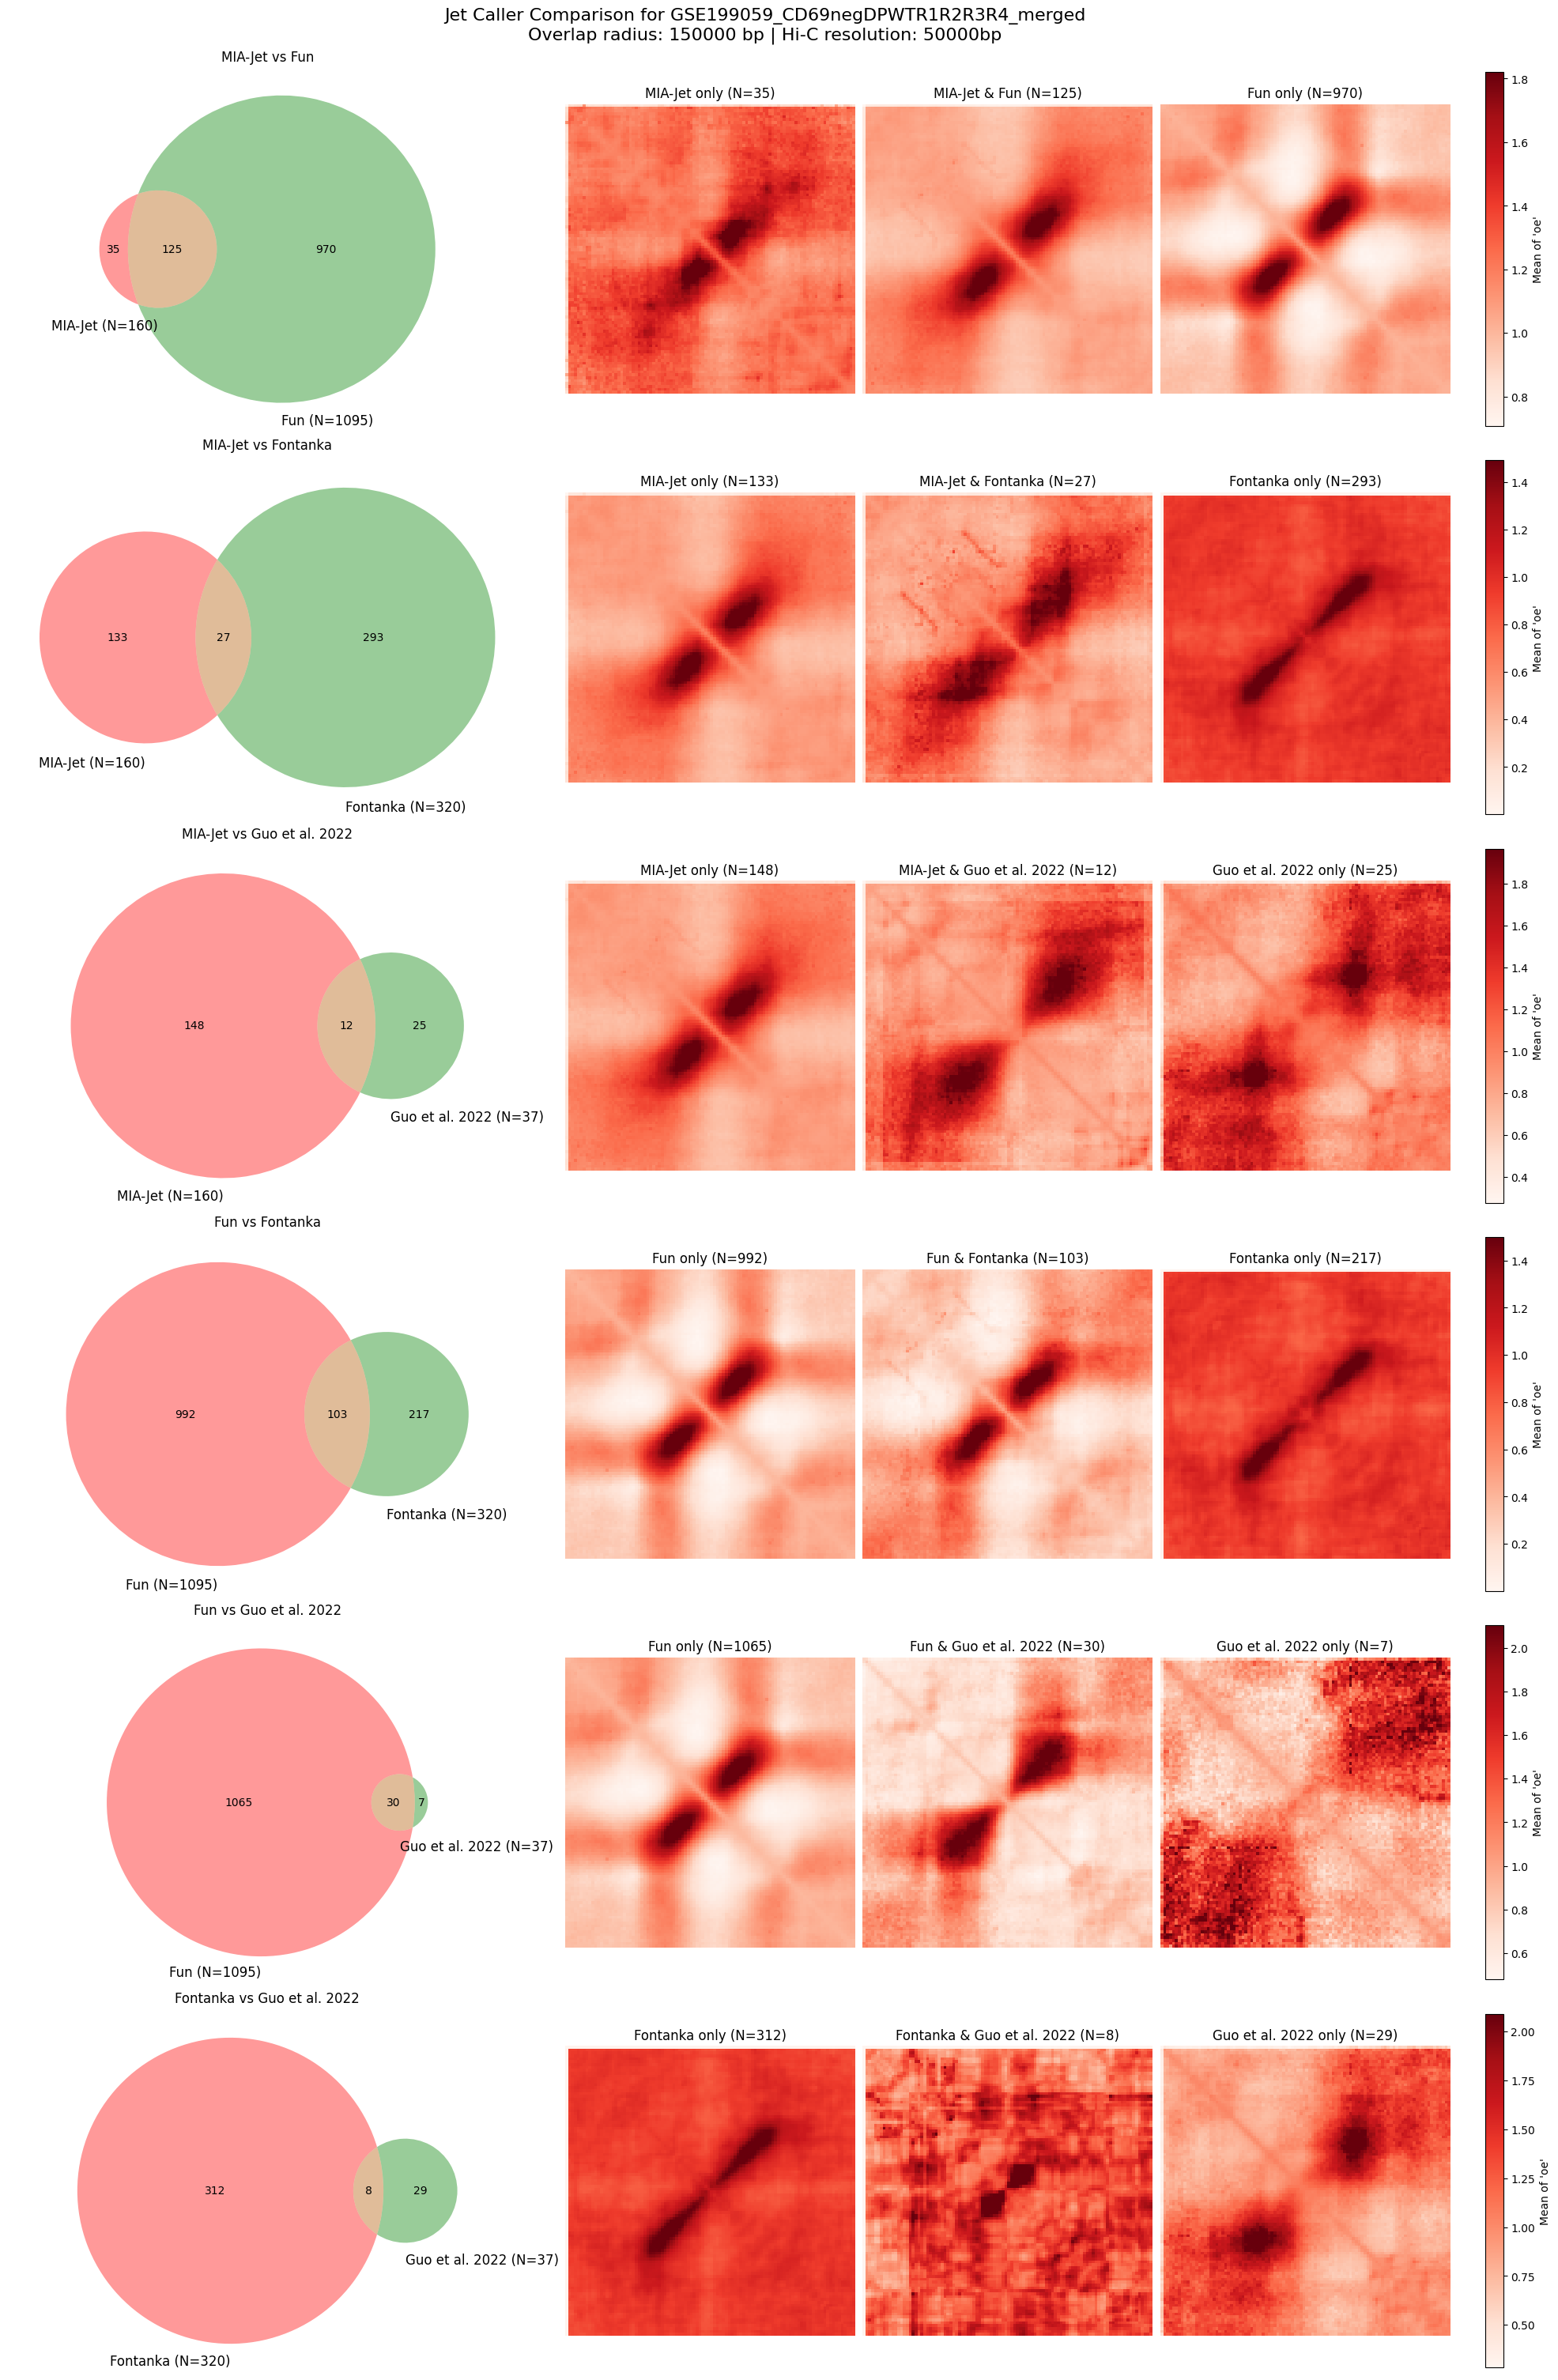

In [ ]:
# every pairwise combination of table names
pairs = list(itertools.combinations(names, 2))
num_pairs = len(pairs)

fig, axes = plt.subplots(num_pairs, 4, figsize=(5*4, 5*num_pairs), layout='constrained', width_ratios=[2, 1, 1, 1])

for row, (A, B) in enumerate(pairs):
    # compute overlaps as before
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter   = results.loc[A, B]
    only_A  = total_A - inter
    only_B  = total_B - inter

    # column 0: the Venn
    ax = axes[row, 0]
    venn2(subsets=(int(only_A), int(only_B), int(inter)),
          set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
          ax=ax)
    ax.set_title(f"{A} vs {B}")

    # columns 1–3: the three imshows
    # agg_map_pairs.shape == (n_pairs, 3, H, W)
    titles = [f"{A} only", f"{A} & {B}", f"{B} only"]
    counts = [int(only_A), int(inter), int(only_B)]
    row_imgs = agg_map_pairs[row]
    row_vmax = max(np.percentile(img, 99) for img in row_imgs)
    for col_idx in range(3):
        ax = axes[row, col_idx+1]
        img = agg_map_pairs[row, col_idx]
        im = ax.imshow(img, cmap="Reds", interpolation="none", vmax=np.percentile(img, 99))
        ax.set_title(f"{titles[col_idx]} (N={counts[col_idx]})")
        ax.axis('off')
    fig.colorbar(im, ax=axes[row, 1:], fraction=0.02, pad=0.04, label=f"Mean of '{data_type}'")


fig.suptitle(f"Jet Caller Comparison for {data_name}\nOverlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution}bp", fontsize=16)

plt.savefig(f"{save_path}/{data_name}_venn_diagram.png", dpi=300)

plt.show()

# Other cell lines

In [ ]:
save_path = "/nfs/turbo/umms-minjilab/sionkim/miajet_analysis"

hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic"
data_name = "Repli-HiC_K562_WT_totalS"

# FUN
f_pred_fun_bedpe = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_Repli-HiC_K562_WT_totalS_hg19/FUN-pred_50000_1.3.bedpe"
f_pred_fun_tab = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FUN_Repli-HiC_K562_WT_totalS_hg19/FUN-pred_50000_1.3.tab"

# FONTANKA
f_pred_fontanka = "/nfs/turbo/umms-minjilab/sionkim/jet_pred/FONTANKA_Repli-HiC_K562_WT_totalS.50000.predicted.fountains.thresholded.tsv"

# MIA-JET
f_pred_miajet_summary = "/nfs/turbo/umms-minjilab/sionkim/miajet_output/Repli-HiC_K562_WT_totalS_chr_combined_50Kb/Repli-HiC_K562_WT_totalS_chr_combined_saliency-90-p-0.1_50Kb_summary_table.csv"
f_pred_miajet_expanded = "/nfs/turbo/umms-minjilab/sionkim/miajet_output/Repli-HiC_K562_WT_totalS_chr_combined_50Kb/Repli-HiC_K562_WT_totalS_chr_combined_saliency-90-p-0.1_50Kb_expanded_table.csv"

genome = "hg19"


# Should be the resolution of the miajet program
# This should be standardized across all methods
# This parameter is used to define the sampling frequency of the jet lines 
resolution = 50000 # 50Kb resolution


# Pileup parameters
expected_stack_size = 100
data_type = "oe"
normalization = "KR"

In [7]:
fun_bedpe = pd.read_csv(f_pred_fun_bedpe, sep="\t")
fun_table = pd.read_csv(f_pred_fun_tab, sep="\t")
fun_table

,chrom,start,end,name,SoN,strand,perc_res_list,max_extension,signal_noise_upstream,signal_noise_downstream,signal_noise_average_background,p_value
0,chr1,97500000,97550000,.,0.000452,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1450.0,1.926158,1.435345,1.644920,0.000674
1,chr1,87700000,87750000,.,0.000701,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",450.0,1.990554,3.178867,2.448130,0.003015
2,chr1,81700000,81750000,.,0.000522,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",650.0,2.348437,1.217904,1.603980,0.000406
3,chr1,80450000,80500000,.,0.001516,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2900.0,1.537960,1.617827,1.576883,0.005182
4,chr1,88700000,88750000,.,0.000778,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",500.0,2.438530,1.406562,1.784063,0.056018
...,...,...,...,...,...,...,...,...,...,...,...,...
1064,chrX,140450000,140500000,.,0.000301,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",250.0,1.192230,1.878190,1.458585,0.018648
1065,chrX,141600000,141650000,.,0.000355,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",250.0,2.503751,1.335099,1.741541,0.018648
1066,chrX,142600000,142650000,.,0.001358,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1250.0,1.818409,1.485109,1.634945,0.000003
1067,chrX,147200000,147250000,.,0.000173,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",400.0,1.012075,1.972344,1.337721,0.059030


In [8]:
fontanka_table = pd.read_csv(f_pred_fontanka, sep="\t", index_col=0)
fontanka_table.dropna(inplace=True, how="any")
fontanka_table.reset_index(inplace=True, drop=True)
fontanka_table

,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr,Scharr_box
0,chr1,7550000,7600000,1550000,13600000,3.283180e-05,0.000009,0.012306,55.119738
1,chr1,13400000,13450000,7400000,19450000,3.963026e-05,0.000020,0.017359,51.694000
2,chr1,22700000,22750000,16700000,28750000,4.864153e-05,0.000061,0.014298,79.541625
3,chr1,27700000,27750000,21700000,33750000,2.822719e-05,0.000014,0.009588,43.572540
4,chr1,37100000,37150000,31100000,43150000,4.755007e-05,0.000055,0.018209,61.073759
...,...,...,...,...,...,...,...,...,...
348,chrY,43800000,43850000,37800000,49850000,-1.939824e-07,0.000012,0.333937,2767.524559
349,chrY,47350000,47400000,41350000,53400000,-2.428165e-05,0.000014,0.000000,2171.368730
350,chrY,49550000,49600000,43550000,55600000,-4.452936e-05,0.000025,0.000000,2171.368730
351,chrY,49900000,49950000,43900000,55950000,-4.130627e-05,0.000035,0.000000,1102.666314


In [9]:
miajet_positions = pd.read_csv(f_pred_miajet_expanded, comment="#")
miajet_table = pd.read_csv(f_pred_miajet_summary, comment="#")
miajet_table

,unique_id,chrom,start,end,length,input_mean,angle_mean,width_mean,jet_saliency,ks,p-val_raw,p-val_corr
0,chr1_269_4,chr1,1.640998e+08,1.642126e+08,200000,0.195,44.322,2.450,0.003,1.000,0.014,0.060
1,chr1_1925_6,chr1,1.043215e+08,1.044906e+08,300000,0.076,117.121,4.159,0.002,1.000,0.001,0.009
2,chr1_146_7,chr1,2.104126e+07,2.124246e+07,300000,0.204,38.710,3.654,0.002,0.833,0.013,0.060
3,chr1_2199_8,chr1,1.532743e+08,1.533726e+08,250000,0.216,128.368,2.429,0.002,1.000,0.004,0.025
4,chr1_1116_13,chr1,1.822610e+08,1.824518e+08,350000,0.169,120.651,6.043,0.002,1.000,0.000,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...
1526,chrX_40_1,chrX,1.477960e+08,1.478077e+08,150000,0.010,124.913,0.000,0.000,1.000,0.050,0.093
1527,chrX_8530_2,chrX,1.558129e+07,1.572006e+07,200000,0.007,81.340,3.245,0.000,1.000,0.014,0.047
1528,chrX_2565_6,chrX,1.651513e+08,1.654356e+08,450000,0.010,48.921,2.888,0.000,0.778,0.003,0.023
1529,chrX_7328_1,chrX,3.168227e+07,3.169963e+07,150000,0.013,121.808,0.000,0.000,1.000,0.050,0.093


In [7]:
# For a fair comparison of overlaps, we will only consider the common chromosomes
common_chroms = set(fun_table["chrom"].unique()) & set(fontanka_table["chrom"].unique()) & set(miajet_table["chrom"].unique())
common_chroms = list(common_chroms)

miajet_table = miajet_table[miajet_table["chrom"].isin(common_chroms)]
fun_table = fun_table[fun_table["chrom"].isin(common_chroms)]
fontanka_table = fontanka_table[fontanka_table["chrom"].isin(common_chroms)]

print(f"Common chromosomes: {common_chroms}")

Common chromosomes: ['chr12', 'chr21', 'chr7', 'chr15', 'chr14', 'chr18', 'chr10', 'chr16', 'chr20', 'chr11', 'chr2', 'chr13', 'chr4', 'chr1', 'chr3', 'chrX', 'chr8', 'chr19', 'chr17', 'chr9', 'chr5', 'chr22', 'chr6']


## Preprocessing

* Need to have positions for each jet, after which we will run the IOU intersection code from the main program

**Invariants of position table**
* `chrom`
* `x (bp)` : the column axis of the Hi-C matrix
* `y (bp)` : the row axis of the Hi-C matrix
* `unique_id` : the unique identifier linking back to the summary dataframe

### miajet

In [8]:
miajet_positions # this is essentially the output invariant we want to have

,unique_id,chrom,x (bp),y (bp),x (pixels),y (pixels),width,angle_imagej,ridge_strength
0,chr1_3459_8,chr1,2.108860e+08,2.087218e+08,5934.565,53.541,3.919,44.243,0.011
1,chr1_3459_8,chr1,2.109325e+08,2.086999e+08,5934.912,52.573,4.003,57.446,0.011
2,chr1_3459_8,chr1,2.109884e+08,2.086819e+08,5935.447,51.527,1.436,70.582,0.011
3,chr1_3459_8,chr1,2.110090e+08,2.086074e+08,5934.686,50.183,4.785,78.052,0.010
4,chr1_3459_8,chr1,2.110364e+08,2.085588e+08,5934.385,49.107,6.435,81.877,0.009
...,...,...,...,...,...,...,...,...,...
34879,chrX_146_1,chrX,1.407019e+08,1.398306e+08,3967.743,71.824,1.435,81.464,0.036
34880,chrX_9205_3,chrX,9.580091e+07,9.367039e+07,2679.943,54.016,1.538,90.758,0.020
34881,chrX_9205_3,chrX,9.576210e+07,9.370265e+07,2679.851,55.021,1.089,92.334,0.018
34882,chrX_109_9,chrX,4.358364e+07,4.173152e+07,1206.953,57.953,4.610,87.622,0.014


### fun

In [9]:
# midpoint
fun_bedpe["extrusion_x"] = (fun_bedpe["y1"] + fun_bedpe["y2"]) / 2
fun_bedpe["extrusion_y"] = (fun_bedpe["x1"] + fun_bedpe["x2"]) / 2


# guarantees that the extrusion point is in the upper diagonal
# doesn't matter except for convention but should be standardized for all points
np.all(fun_bedpe["extrusion_x"] >= fun_bedpe["extrusion_y"])


# extrusion positions define the ending point of the jet 
# the root position of jet is the starting point of the jet, which can be computed from the main table
fun_bedpe

,chr1,x1,x2,chr2,y1,y2,extrusion_x,extrusion_y
0,chr1,248475000,248525000,chr1,249175000,249225000,249200000.0,248500000.0
1,chr1,245425000,245475000,chr1,245925000,245975000,245950000.0,245450000.0
2,chr1,243025000,243075000,chr1,243725000,243775000,243750000.0,243050000.0
3,chr1,242725000,242775000,chr1,243725000,243775000,243750000.0,242750000.0
4,chr1,242225000,242275000,chr1,242925000,242975000,242950000.0,242250000.0
...,...,...,...,...,...,...,...,...
1248,chrX,101775000,101825000,chrX,102975000,103025000,103000000.0,101800000.0
1249,chrX,101725000,101775000,chrX,103225000,103275000,103250000.0,101750000.0
1250,chrX,106175000,106225000,chrX,106675000,106725000,106700000.0,106200000.0
1251,chrX,105625000,105675000,chrX,108025000,108075000,108050000.0,105650000.0


In [10]:
# the main table hosts the "start" and "end" positions, which is the main diagonal start and end
# to get a single point for the jet, we can use the midpoint of the start and end positions
fun_table["root"] = (fun_table["start"] + fun_table["end"]) / 2
# Note that "root" position should technically be "root_x" and "root_y" but since 
# this is a point on the main diagonal, they are the same and we can just use one value

# Lets add a unique identifier now
fun_table["unique_id"] = fun_table.index

fun_table

,chrom,start,end,name,SoN,strand,perc_res_list,max_extension,signal_noise_upstream,signal_noise_downstream,signal_noise_average_background,p_value,root,unique_id
0,chr1,248800000,248850000,.,0.034725,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",350.0,2.764008,14.271486,4.631095,0.031436,248825000.0,0
1,chr1,245650000,245700000,.,0.016171,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",250.0,2.075779,1.411330,1.680251,0.087024,245675000.0,1
2,chr1,243350000,243400000,.,0.013129,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",350.0,1.870830,1.113887,1.396376,0.099547,243375000.0,2
3,chr1,243200000,243250000,.,0.015958,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",500.0,1.416172,1.438078,1.427041,0.056018,243225000.0,3
4,chr1,242550000,242600000,.,0.021520,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",350.0,2.071704,1.476585,1.724238,0.007859,242575000.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,chrX,102350000,102400000,.,0.020841,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",600.0,1.510178,1.810567,1.646786,0.049347,102375000.0,1248
1249,chrX,102450000,102500000,.,0.022493,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",750.0,1.838026,1.943704,1.889389,0.010890,102475000.0,1249
1250,chrX,106400000,106450000,.,0.016214,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",250.0,3.209240,1.192248,1.738599,0.087024,106425000.0,1250
1251,chrX,106800000,106850000,.,0.033477,.,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1200.0,1.295163,3.166704,1.838422,0.027658,106825000.0,1251


In [11]:
# Lets combine them
fun_minimal = fun_bedpe.copy()

fun_minimal["root"] = fun_table["root"]

# Lets add a unique identifier now
fun_minimal["unique_id"] = fun_minimal.index
fun_minimal["chrom"] = fun_table["chrom"]

fun_minimal = fun_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

fun_minimal

,unique_id,chrom,root,extrusion_x,extrusion_y
0,0,chr1,248825000.0,249200000.0,248500000.0
1,1,chr1,245675000.0,245950000.0,245450000.0
2,2,chr1,243375000.0,243750000.0,243050000.0
3,3,chr1,243225000.0,243750000.0,242750000.0
4,4,chr1,242575000.0,242950000.0,242250000.0
...,...,...,...,...,...
1248,1248,chrX,102375000.0,103000000.0,101800000.0
1249,1249,chrX,102475000.0,103250000.0,101750000.0
1250,1250,chrX,106425000.0,106700000.0,106200000.0
1251,1251,chrX,106825000.0,108050000.0,105650000.0


In [14]:
fun_positions = generate_positions(fun_minimal, resolution)
fun_positions["unique_id"] = fun_positions["unique_id"].astype(int)

In [15]:
fun_positions # done

,unique_id,chrom,x (bp),y (bp)
0,0,chr1,2.492000e+08,2.485000e+08
1,0,chr1,2.491583e+08,2.485361e+08
2,0,chr1,2.491167e+08,2.485722e+08
3,0,chr1,2.490750e+08,2.486083e+08
4,0,chr1,2.490333e+08,2.486444e+08
...,...,...,...,...
25383,1252,chrX,1.071250e+08,1.068393e+08
25384,1252,chrX,1.070875e+08,1.068732e+08
25385,1252,chrX,1.070500e+08,1.069071e+08
25386,1252,chrX,1.070125e+08,1.069411e+08


### fontanka

In [16]:
fontanka_table

,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr,Scharr_box
0,chr1,14050000,14100000,8050000,20100000,0.000041,0.000050,0.050575,220.913348
1,chr1,21750000,21800000,15750000,27800000,0.000026,0.000020,0.046696,1533.578868
2,chr1,30350000,30400000,24350000,36400000,0.000019,0.000013,0.042538,185.805939
3,chr1,34600000,34650000,28600000,40650000,0.000026,0.000021,0.047915,209.293356
4,chr1,42000000,42050000,36000000,48050000,0.000030,0.000028,0.090370,394.735974
...,...,...,...,...,...,...,...,...,...
389,chrX,113700000,113750000,107700000,119750000,0.000045,0.000043,0.110848,842.848206
390,chrX,121100000,121150000,115100000,127150000,0.000036,0.000036,0.226383,988.839469
391,chrX,126350000,126400000,120350000,132400000,0.000067,0.000072,0.134746,600.998801
392,chrX,132150000,132200000,126150000,138200000,0.000045,0.000038,0.256204,1119.099959


In [17]:
fontanka_table = fontanka_table.reset_index(drop=True)
fontanka_table["root"] = (fontanka_table["end"] + fontanka_table["start"]) / 2
fontanka_table["unique_id"] = fontanka_table.index
fontanka_table["extrusion_x"] = fontanka_table["window_end"]
fontanka_table["extrusion_y"] = fontanka_table["window_start"]

fontanka_table


,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr,Scharr_box,root,unique_id,extrusion_x,extrusion_y
0,chr1,14050000,14100000,8050000,20100000,0.000041,0.000050,0.050575,220.913348,14075000.0,0,20100000,8050000
1,chr1,21750000,21800000,15750000,27800000,0.000026,0.000020,0.046696,1533.578868,21775000.0,1,27800000,15750000
2,chr1,30350000,30400000,24350000,36400000,0.000019,0.000013,0.042538,185.805939,30375000.0,2,36400000,24350000
3,chr1,34600000,34650000,28600000,40650000,0.000026,0.000021,0.047915,209.293356,34625000.0,3,40650000,28600000
4,chr1,42000000,42050000,36000000,48050000,0.000030,0.000028,0.090370,394.735974,42025000.0,4,48050000,36000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,chrX,113700000,113750000,107700000,119750000,0.000045,0.000043,0.110848,842.848206,113725000.0,389,119750000,107700000
390,chrX,121100000,121150000,115100000,127150000,0.000036,0.000036,0.226383,988.839469,121125000.0,390,127150000,115100000
391,chrX,126350000,126400000,120350000,132400000,0.000067,0.000072,0.134746,600.998801,126375000.0,391,132400000,120350000
392,chrX,132150000,132200000,126150000,138200000,0.000045,0.000038,0.256204,1119.099959,132175000.0,392,138200000,126150000


In [18]:
# guarantees that the extrusion point is in the upper diagonal
# doesn't matter except for convention but should be standardized for all points
np.all(fontanka_table["extrusion_x"] >= fontanka_table["extrusion_y"])

True

In [19]:
fontanka_minimal = fontanka_table.copy()

fontanka_minimal = fontanka_minimal[["unique_id", "chrom", "root", "extrusion_x", "extrusion_y"]]

fontanka_minimal

,unique_id,chrom,root,extrusion_x,extrusion_y
0,0,chr1,14075000.0,20100000,8050000
1,1,chr1,21775000.0,27800000,15750000
2,2,chr1,30375000.0,36400000,24350000
3,3,chr1,34625000.0,40650000,28600000
4,4,chr1,42025000.0,48050000,36000000
...,...,...,...,...,...
389,389,chrX,113725000.0,119750000,107700000
390,390,chrX,121125000.0,127150000,115100000
391,391,chrX,126375000.0,132400000,120350000
392,392,chrX,132175000.0,138200000,126150000


In [20]:
fontanka_positions = generate_positions(fontanka_minimal, resolution)
fontanka_positions["unique_id"] = fontanka_positions["unique_id"].astype(int)

In [21]:
fontanka_positions

,unique_id,chrom,x (bp),y (bp)
0,0,chr1,2.010000e+07,8.050000e+06
1,0,chr1,2.006456e+07,8.085441e+06
2,0,chr1,2.002912e+07,8.120882e+06
3,0,chr1,1.999368e+07,8.156324e+06
4,0,chr1,1.995824e+07,8.191765e+06
...,...,...,...,...
67369,393,chrX,1.439168e+08,1.436332e+08
67370,393,chrX,1.438813e+08,1.436687e+08
67371,393,chrX,1.438459e+08,1.437041e+08
67372,393,chrX,1.438104e+08,1.437396e+08


### Summary

In [22]:
miajet_positions

,unique_id,chrom,x (bp),y (bp),x (pixels),y (pixels),width,angle_imagej,ridge_strength
0,chr1_3459_8,chr1,2.108860e+08,2.087218e+08,5934.565,53.541,3.919,44.243,0.011
1,chr1_3459_8,chr1,2.109325e+08,2.086999e+08,5934.912,52.573,4.003,57.446,0.011
2,chr1_3459_8,chr1,2.109884e+08,2.086819e+08,5935.447,51.527,1.436,70.582,0.011
3,chr1_3459_8,chr1,2.110090e+08,2.086074e+08,5934.686,50.183,4.785,78.052,0.010
4,chr1_3459_8,chr1,2.110364e+08,2.085588e+08,5934.385,49.107,6.435,81.877,0.009
...,...,...,...,...,...,...,...,...,...
34879,chrX_146_1,chrX,1.407019e+08,1.398306e+08,3967.743,71.824,1.435,81.464,0.036
34880,chrX_9205_3,chrX,9.580091e+07,9.367039e+07,2679.943,54.016,1.538,90.758,0.020
34881,chrX_9205_3,chrX,9.576210e+07,9.370265e+07,2679.851,55.021,1.089,92.334,0.018
34882,chrX_109_9,chrX,4.358364e+07,4.173152e+07,1206.953,57.953,4.610,87.622,0.014


In [23]:
fontanka_positions

,unique_id,chrom,x (bp),y (bp)
0,0,chr1,2.010000e+07,8.050000e+06
1,0,chr1,2.006456e+07,8.085441e+06
2,0,chr1,2.002912e+07,8.120882e+06
3,0,chr1,1.999368e+07,8.156324e+06
4,0,chr1,1.995824e+07,8.191765e+06
...,...,...,...,...
67369,393,chrX,1.439168e+08,1.436332e+08
67370,393,chrX,1.438813e+08,1.436687e+08
67371,393,chrX,1.438459e+08,1.437041e+08
67372,393,chrX,1.438104e+08,1.437396e+08


In [24]:
fun_positions

,unique_id,chrom,x (bp),y (bp)
0,0,chr1,2.492000e+08,2.485000e+08
1,0,chr1,2.491583e+08,2.485361e+08
2,0,chr1,2.491167e+08,2.485722e+08
3,0,chr1,2.490750e+08,2.486083e+08
4,0,chr1,2.490333e+08,2.486444e+08
...,...,...,...,...
25383,1252,chrX,1.071250e+08,1.068393e+08
25384,1252,chrX,1.070875e+08,1.068732e+08
25385,1252,chrX,1.070500e+08,1.069071e+08
25386,1252,chrX,1.070125e+08,1.069411e+08


## Intersection


**WARNING: need to run the following code separately for each chromosome and combine!**

In [28]:
# Expanded
positions = [
    miajet_positions,
    fun_positions,
    fontanka_positions
]

# Summary
tables = [
    miajet_table,
    fun_table,
    fontanka_table
]

names = [
    "MIA-Jet",
    "Fun",
    "Fontanka"
]

position_dict = dict(zip(names, positions))
table_dict = dict(zip(names, tables))

In [58]:
buffer_radius = 3 * resolution  # 5 bins
iou_threshold = 0  # ANY overlap

In [59]:
results = pd.DataFrame(index=names, columns=names, dtype=int).fillna(0)
unique_identifiers = []
name_pairs = []
# fill main diagonal with the total number of jets from each method
for n in names:
    results.loc[n, n] = len(table_dict[n])

for n1, n2 in itertools.combinations(names, 2):

    print("-" * 20)
    print(f"Comparing {n1} and {n2}...")


    genome_wide_overlap = 0
    identifiers = []

    for chrom in common_chroms:
        # IOU method is per-chromosome so filter each table by chromosome
        t1 = position_dict[n1].loc[position_dict[n1]["chrom"] == chrom]
        t2 = position_dict[n2].loc[position_dict[n2]["chrom"] == chrom]

        # Summary tables to get the number of jets called by each method
        s1 = table_dict[n1].loc[table_dict[n1]["chrom"] == chrom]
        s2 = table_dict[n2].loc[table_dict[n2]["chrom"] == chrom]

        # Compute the pairs of jets in each direction
        pairs12 = match_by_iou(t1, t2, buffer_radius, iou_threshold)
        pairs21 = match_by_iou(t2, t1, buffer_radius, iou_threshold)

        # Construct graph and find unique pairs
        pairs = unique_pairs(pairs12, pairs21, method="optimal")

        # print(f"* {chrom}: {len(pairs)} pairs between {n1} ({len(s1)}) and {n2} ({len(s2)})")

        genome_wide_overlap += len(pairs)
        identifiers += pairs # extend the list

    # Update reuslts table
    results.loc[n1, n2] = genome_wide_overlap
    results.loc[n2, n1] = genome_wide_overlap  # symmetric

    unique_identifiers.append(identifiers)
    name_pairs.append((n1, n2))
    
print("Genome-wide overlaps:")
print(results)

--------------------
Comparing MIA-Jet and Fun...
--------------------
Comparing MIA-Jet and Fontanka...
--------------------
Comparing Fun and Fontanka...
Genome-wide overlaps:
          MIA-Jet     Fun  Fontanka
MIA-Jet    1757.0   563.0     215.0
Fun         563.0  1253.0     114.0
Fontanka    215.0   114.0     394.0


In [ ]:
def safe_int(x):
    try:
        return int(x)
    except ValueError:
        return x

In [121]:
# Plot in a loop
agg_map_pairs = []
for (n1, n2), pairs in zip(name_pairs, unique_identifiers):

    # vectorize the function (so it applies element-wise)
    safe_convert = np.vectorize(safe_int)

    # Construct bed dataframes from the unique identifier pairs 
    df_intersections = []

    uid1 = np.array(pairs)[:, 0]  # unique identifiers from n1
    uid2 = np.array(pairs)[:, 1]  # unique identifiers from n2

    uid1 = safe_convert(uid1)
    uid2 = safe_convert(uid2)

    df1 = pd.DataFrame({"unique_id" : uid1,})
    df2 = pd.DataFrame({"unique_id" : uid2,})

    # Lets do a merge of the summary table and the unique identifiers
    # We may now use any of df1 OR df2 (any – shouldn't matter) to construct the bed dataframe
    # to plot the aggregate jet positions

    # Use n1
    A_name = n1
    B_name = n2
    # Summary dataframe
    df_A = table_dict[n1]
    df_B = table_dict[n2]
    # IDs from the returned unique pairs
    # These will be used to merge to extract the relevant positions
    df_id = df1
    df_id_alt = df2
    # Expanded dataframe 
    df_pos_A = position_dict[n1].copy()
    df_pos_B = position_dict[n2].copy()

    # These are the "main" summary dataframes
    # That should be sufficien to plot the aggregate contact maps
    df_intersection = df_A[df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_diff_A = df_A[~df_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_diff_B = df_B[~df_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    # Assertions to ensure that the intersection and difference cover the whole table
    assert len(df_intersection) + len(df_diff_A) == len(df_A), "The intersection and difference should cover the whole table"
    assert len(df_intersection) + len(df_diff_B) == len(df_B), "The intersection and difference should cover the whole table"

    # Lets get the positions, which is better to plot the individual Hi-C diagnostic plots
    # These diagnostic plots are meant to confirm that the overlapping parameters are good
    df_pos_intersection = df_pos_A[df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_pos_diff_A = df_pos_A[~df_pos_A["unique_id"].isin(df_id["unique_id"])].reset_index(drop=True)
    df_pos_diff_B = df_pos_B[~df_pos_B["unique_id"].isin(df_id_alt["unique_id"])].reset_index(drop=True)

    # plot_overlap_diagnostic(
    #     hic_file=hic_file,
    #     plot_chrom=common_chroms[0],  
    #     resolution=resolution,
    #     data_type="observed",
    #     normalization="VC_SQRT",
    #     A_name=A_name,
    #     B_name=B_name,
    #     df_pos_A=df_pos_A,
    #     df_pos_B=df_pos_B,
    #     df_pos_intersection=df_pos_intersection,
    #     df_pos_diff_A=df_pos_diff_A,
    #     df_pos_diff_B=df_pos_diff_B,
    #     save_path=save_path,
    #     data_name=data_name
    # )

    bed_intersection = generate_bed_df(df_intersection, df_pos_intersection, eps=500e3, fraction=0.5)
    bed_diff_A = generate_bed_df(df_diff_A, df_pos_diff_A, eps=500e3, fraction=0.5)
    bed_diff_B = generate_bed_df(df_diff_B, df_pos_diff_B, eps=500e3, fraction=0.5)
        

    chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

    bed_frames = [bed_diff_A, bed_intersection, bed_diff_B]
    bed_names = [f"{A_name} only", f"{A_name} & {B_name}", f"{B_name} only"]


    agg_map = []
    # resolutions = []
    for bed_df, name in zip(bed_frames, bed_names):
        # Get pileups for each bed_df
        s, d, r = get_pileups_dynamic_resolution(
            hic_file=hic_file,
            bed_df_in=bed_df,
            expected_stack_size=expected_stack_size,
            chrom_sizes=chrom_sizes,
            chromosomes='all',
            window_range=(None, None),
            data_type=data_type,
            normalization=normalization,
            sort=True,
            verbose=True
        )

        # Remove centromeres and resize square stacks
        s, d = remove_and_resize_square_stacks(s, d, expected_stack_size)

        if data_type == "observed":
            s = np.log10(s + 1) # log transform for visualization

        agg_map.append(np.mean(s, axis=0))  # average over all stacks
        # resolutions.append(r)

    agg_map_pairs.append(agg_map)

Retrieving pileups: 100%|██████████| 280/280 [00:03<00:00, 92.67it/s] 


In [122]:
agg_map_pairs = np.array(agg_map_pairs)

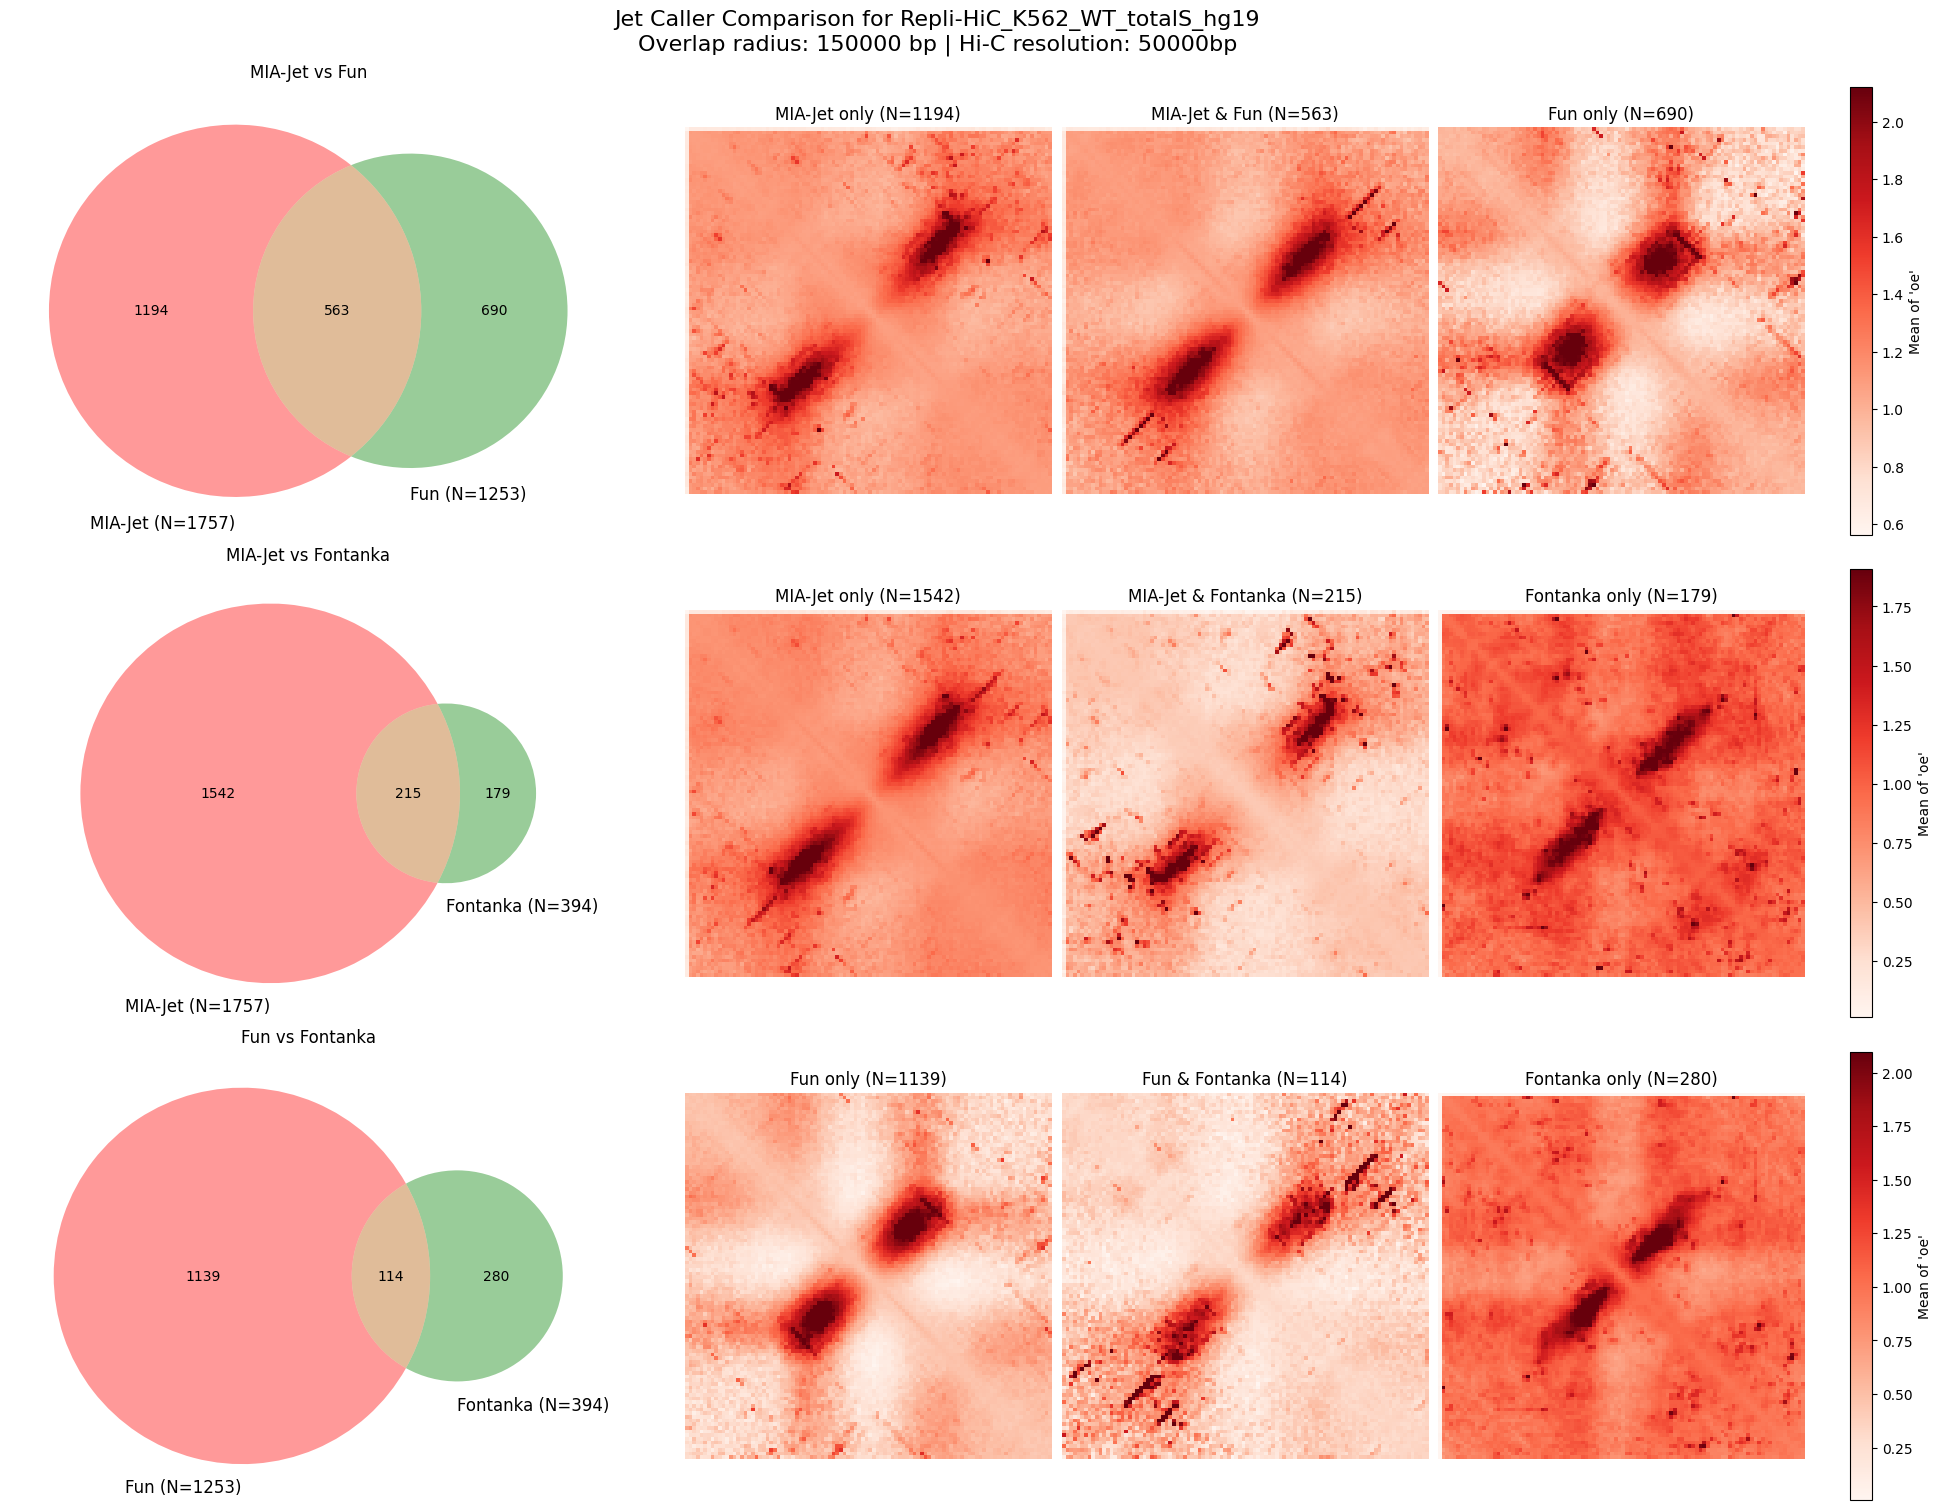

In [ ]:
agg_map_pairs.shape 
# number of pair combinations, (A only, A&B, B only), stack size, stack size

# every pairwise combination of table names
pairs = list(itertools.combinations(names, 2))
num_pairs = len(pairs)

fig, axes = plt.subplots(num_pairs, 4, figsize=(5*4, 5*num_pairs), layout='constrained', width_ratios=[2, 1, 1, 1])

for row, (A, B) in enumerate(pairs):
    # compute overlaps as before
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter   = results.loc[A, B]
    only_A  = total_A - inter
    only_B  = total_B - inter

    # column 0: the Venn
    ax = axes[row, 0]
    venn2(subsets=(int(only_A), int(only_B), int(inter)),
          set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"),
          ax=ax)
    ax.set_title(f"{A} vs {B}")

    # columns 1–3: the three imshows
    # agg_map_pairs.shape == (n_pairs, 3, H, W)
    titles = [f"{A} only", f"{A} & {B}", f"{B} only"]
    counts = [int(only_A), int(inter), int(only_B)]
    row_imgs = agg_map_pairs[row]
    row_vmax = max(np.percentile(img, 99) for img in row_imgs)
    for col_idx in range(3):
        ax = axes[row, col_idx+1]
        img = agg_map_pairs[row, col_idx]
        im = ax.imshow(img, cmap="Reds", interpolation="none", vmax=np.percentile(img, 99))
        ax.set_title(f"{titles[col_idx]} (N={counts[col_idx]})")
        ax.axis('off')
    fig.colorbar(im, ax=axes[row, 1:], fraction=0.02, pad=0.04, label=f"Mean of '{data_type}'")


fig.suptitle(f"Jet Caller Comparison for {data_name}\nOverlap radius: {int(buffer_radius)} bp | Hi-C resolution: {resolution}bp", fontsize=16)

plt.savefig(f"{save_path}/{data_name}_venn_diagram.png", dpi=300)


plt.show()

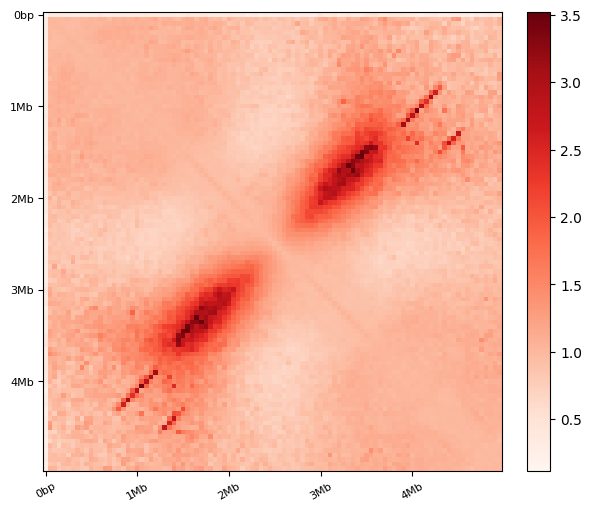

In [111]:
plot_hic(
    agg_map,
    title=f"",
    resolution=resolution,
    cmap='Reds',
    # savepath=f"{save_folder}/{experiment_name}_agg_map-{data_type}-{normalization}.png"
)

In [56]:
# # Diagnostic 
# # Has some interesting results when the buffer radius is made extremely large... Whats happening?
# miajet_positions_chrom = miajet_positions.loc[miajet_positions["chrom"] == common_chroms[0]]
# fontanka_positions_chrom = fontanka_positions.loc[fontanka_positions["chrom"] == common_chroms[0]]

# for br in [0, 1000, 5000, 50_000, int(50e3), int(50e3) * 3, int(50e3) * 5, 5_000_000, 50_000_000, 500_000_000]:
#     pairs_miajet_fontanka = match_by_iou(miajet_positions_chrom, fontanka_positions_chrom, br, 0.0)
#     pairs_fontanka_miajet = match_by_iou(fontanka_positions_chrom, miajet_positions_chrom, br, 0.0)

#     unique_opt = unique_pairs(pairs_fontanka_miajet, pairs_miajet_fontanka, method="greedy")

#     print(f"Buffer radius: {br} gives # unique pairs (greedy): {len(unique_opt)}")

#     unique_opt = unique_pairs(pairs_fontanka_miajet, pairs_miajet_fontanka, method="optimal")

#     print(f"Buffer radius: {br} gives # unique pairs (optimal): {len(unique_opt)}")


# print(f"Number of jets in MIA-Jet table for {common_chroms[0]}: {len(miajet_table.loc[miajet_table['chrom'] == common_chroms[0]])}")
# print(f"Number of jets in Fontanka table for {common_chroms[0]}: {len(fontanka_table.loc[fontanka_table['chrom'] == common_chroms[0]])}")

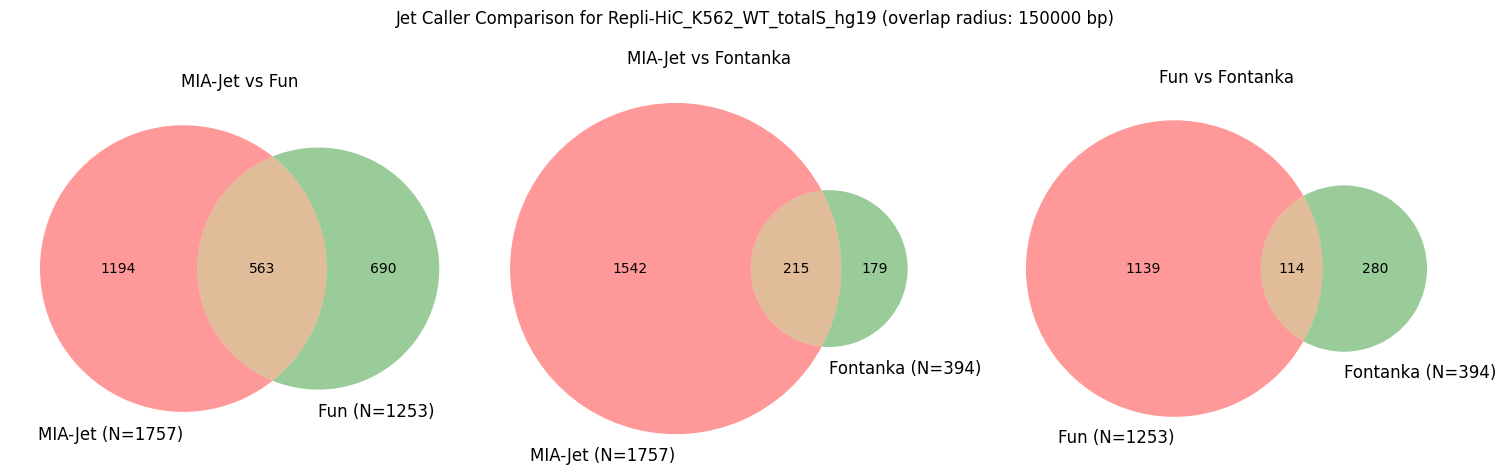

In [65]:
# every pairwise combination of table names
pairs = list(itertools.combinations(names, 2))

fig, axes = plt.subplots(1, len(pairs), figsize=(5 * len(pairs), 5), layout='constrained')

for ax, (A, B) in zip(axes, pairs):
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter   = results.loc[A, B]  # # of A features shared with B
    
    only_A = total_A - inter
    only_B = total_B - inter

    venn2(subsets=(int(only_A), int(only_B), int(inter)), set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"), ax=ax)
    ax.set_title(f"{A} vs {B}")

fig.suptitle(f"Jet Caller Comparison for {data_name} (overlap radius: {int(buffer_radius)} bp)")

plt.show()  


In [7]:
# Define tables
tables = [
    miajet_table,
    fun_table,
    fontanka_table
]

table_names = [
    "MIA-Jet",
    "Fun",
    "Fontanka"
]

table_dict = dict(zip(table_names, tables))

In [22]:
def _chrom_order(chrom):
    """
    Map chr names to an integer order
    """
    m = re.match(r'^chr(\d+)$', chrom)
    if m:
        return int(m.group(1))
    if chrom in ('chrX', 'X'):
        return 23
    if chrom in ('chrY', 'Y'):
        return 24
    if chrom in ('chrM', 'chrMT', 'MT'):
        return 25
    # put everything else at the end
    return float('inf')



bedtools = dict()
for i, t in enumerate(tables):
    df_bed = t.copy()
    df_bed = df_bed[["chrom", "start", "end"]].astype({'start':int,'end':int})
    # df_bed[["start", "end"]] = df_bed[["start", "end"]].astype(int)

    # sort by chromosome
    df_bed["chrom_order"] = df_bed["chrom"].apply(_chrom_order)
    df_bed.sort_values(by=["chrom_order", "start", "end"], inplace=True)
    df_bed.drop(columns=["chrom_order"], inplace=True)
    
    bedtools[table_names[i]] = pybedtools.BedTool.from_dataframe(df_bed)

In [23]:
def count_bedtool_intersect(a_bt, b_bt, w, **kwargs):
    """
    Return the total number of pairwise overlaps between two BedTools objects
    """
    pairs1 = a_bt.intersect(b_bt, wa=True, wb=True, **kwargs)
    pairs2 = b_bt.intersect(a_bt, wa=True, wb=True, **kwargs)

    assert pairs1.count() == pairs2.count(), "Counts are not symmetric"

    df_pairs = pairs1.to_dataframe(names=[
        'chrom_A','start_A','end_A',
        'chrom_B','start_B','end_B',
    ])

    return df_pairs, pairs1.count()


In [42]:
results = pd.DataFrame(index=table_names, columns=table_names, dtype=int).fillna(0)

# fill main diagonal with the total number of jets from each method
for name, df in zip(table_names, tables):
    results.loc[name, name] = len(df)

# Leniency ± window size (bp)
# window_size = int(50e3 * 3)
# window_size = 3000
window_size = int(50e3 * 10000)

# for clamping the leniency slop funcitonality
# chromsizes = bf.fetch_chromsizes(genome)
df_pairs = []

for n1, n2 in itertools.combinations(table_names, 2):
    a_bt = bedtools[n1]
    b_bt = bedtools[n2]

    a_bt_slop = a_bt.slop(b=window_size, genome=genome)
    b_bt_slop = b_bt.slop(b=window_size, genome=genome)

    df_ab = a_bt_slop.intersect(b_bt_slop, 
                                wa=True, # simply whether to add the A and B data to the dataframe output (duh)
                                wb=True, 
                                u=True # essentially, if A matches WITH ANYTHING in B only report it ONCE (as oppposed to being copied multiple times for each overlap)
                                ).to_dataframe(names=["chrom_A", "start_A", "end_A", "chrom_B", "start_B", "end_B"])
    df_ba = b_bt_slop.intersect(a_bt_slop, 
                                wa=True, 
                                wb=True, 
                                u=True
                                ).to_dataframe(names=["chrom_A", "start_A", "end_A", "chrom_B", "start_B", "end_B"])



    break

    # assert count_1 == count_2, "Counts are not symmetric"

    # results.loc[n1, n2] = count_1
    # results.loc[n2, n1] = count_1

    # df_pairs.append(df_ab)

results

,MIA-Jet,Fun,Fontanka
MIA-Jet,1757.0,0.0,0.0
Fun,0.0,1253.0,0.0
Fontanka,0.0,0.0,7154.0


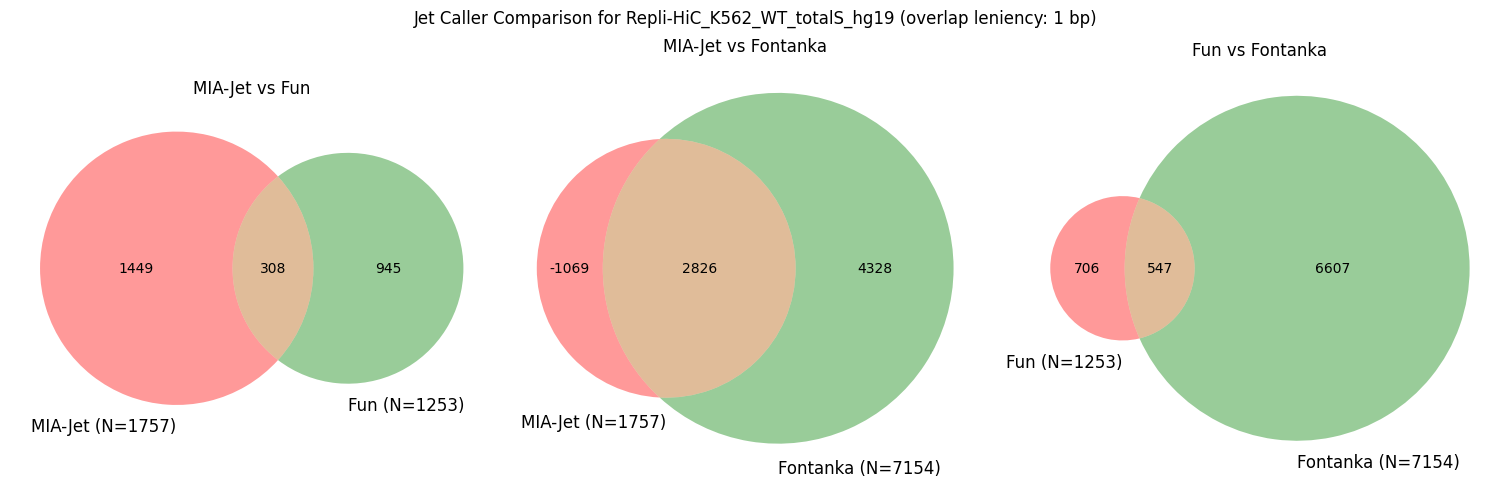

In [143]:
# every pairwise combination of table names
pairs = list(itertools.combinations(table_names, 2))

fig, axes = plt.subplots(1, len(pairs), figsize=(5 * len(pairs), 5), layout='constrained')

for ax, (A, B) in zip(axes, pairs):
    total_A = results.loc[A, A]
    total_B = results.loc[B, B]
    inter   = results.loc[A, B]  # # of A features shared with B
    
    only_A = total_A - inter
    only_B = total_B - inter

    venn2(subsets=(int(only_A), int(only_B), int(inter)), set_labels=(f"{A} (N={int(total_A)})", f"{B} (N={int(total_B)})"), ax=ax)
    ax.set_title(f"{A} vs {B}")

fig.suptitle(f"Jet Caller Comparison for {data_name} (overlap leniency: {int(window_size)} bp)")

plt.show()  
